In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random
from keras.datasets import mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda,Embedding, Reshape, Activation
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D,AveragePooling1D,Conv1D, GlobalMaxPooling1D, MaxPooling1D,GlobalAveragePooling1D
from keras import backend as K
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold 

In [2]:
#Siamese Network Implementation 
num_classes = 12
epochs = 20
 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs_new3(x, digit_indices):
    pairs = []
    labels = []
    
    for d in range(num_classes):
        #n'i içeri aldım böylese her class için max loop yapabiliyoruz.
        n=min([len(digit_indices[d])]) -1
        for i in range(n):
            #Random bir Equal index buluyoruz while kullanarak, kendisi(i) haric
            #randomIndiceTrue = random.randrange(0, min([len(digit_indices[d])]))
            randomIndiceTrue=-1
            while True:
                if randomIndiceTrue != i:
                    break
                else:
                    randomIndiceTrue = random.randrange(0, min([len(digit_indices[d])]))
            
            z1, z2 = digit_indices[d][i], digit_indices[d][randomIndiceTrue]
            pairs += [[x[z1], x[z2]]]
            
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            
            #Random bir Non Equal index buluyoruz.
            randomIndiceFalse = random.randrange(0, min([len(digit_indices[dn])]))
            
            z1, z2 = digit_indices[d][i], digit_indices[dn][randomIndiceFalse]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
    return np.array(pairs), np.array(labels)



def create_base_net_new2(input_shape):
    height=376
    depth=1
    num_classes=12
    input = Input(shape = input_shape)
    #x = Sequential()(input)
    x = Reshape((height, depth))(input)
    x = Conv1D(12, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(8, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(6, 3, strides=1, padding='valid', activation='relu')(x)
    #x = AveragePooling1D(3)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation = 'relu')(x)
    model = Model(input, x)
    model.summary()
    #print(model.summary())
    return model


def get_f1(y_true, y_pred): 
    pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def compute_f1(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    pred=pred*1
    TN,FP,FN,TP=confusion_matrix(y_true, pred).ravel()

    recall = TP/(TP+FN)
    precision=TP/(TP+FP)

    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def compute_cosine_f1(t_pairs, t_y):
    cosine_threshold=0.6
    cTP=0
    cFP=0
    cFN=0
    cTN=0
    for i in range(np.shape(t_y)[0]):
        cos_result=cosine_similarity(t_pairs[i, 0].reshape(1, -1), t_pairs[i, 1].reshape(1, -1))
        if t_y[i]==1 and cos_result>=cosine_threshold:
            cTP=cTP+1
        elif t_y[i]!=1 and cos_result>=cosine_threshold:
            cFP=cFP+1
        elif t_y[i]==1 and cos_result<cosine_threshold:
            cFN=cFN+1
        elif t_y[i]!=1 and cos_result<cosine_threshold:
            cTN=cTN+1
        
    recall = cTP/(cTP+cFN)
    
    precision=cTP/(cTP+cFP)
    f1_cosine_val = 2*(precision*recall)/(precision+recall)
    return f1_cosine_val
    

In [3]:
#Dataset
df=pd.read_csv('db_dep_dataset_1_noname.csv',delimiter=';',header=None)
df
# Table names are anonymized.
# First column: TABLE_UniqueTableNumber_ModuleNumber
# Second column: Class number. Equal to Module Number-1. There are 12 classes in totally.
# Third column: Unique table number

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
0,TABLE_1_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TABLE_2_1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TABLE_3_1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TABLE_4_1,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TABLE_5_1,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,TABLE_116_12,11,116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,TABLE_117_12,11,117,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,TABLE_118_12,11,118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,TABLE_119_12,11,119,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Separation X and Y values
Y = df[1]

Y=Y.values

#First three columns removed.
X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)

X=X.values

In [5]:
Y = df[1]

Y=Y.values

X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)
X=X.values

cvTestscoresSiameseAll=[]
cvTestscoresCosineAll=[]

for i in range(100):
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    cvTrainscores = []
    cvTestscores = []
    cvi=0
    cvTrainscoresCosine = []
    cvTestscoresCosine = []
    
    for train, test in kfold.split(X, Y):
        
        cvi=cvi+1
        print("n-fold: "+str(cvi))

        x_train = X[train]
        x_test = X[test]
        y_train = Y[train]
        y_test = Y[test]

        x_train = x_train.reshape(x_train.shape[0], 376, 1)
        x_test = x_test.reshape(x_test.shape[0], 376, 1)
        input_shape = (376, 1)
        print(x_train.shape)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')
        input_shape = (376,1)

        print(input_shape)

        # create training+test positive and negative pairs
        digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
        tr_pairs, tr_y = create_pairs_new3(x_train, digit_indices)

        digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
        te_pairs, te_y = create_pairs_new3(x_test, digit_indices)

        # network definition
        base_network = create_base_net_new2(input_shape)

        print(input_shape)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        distance = Lambda(euclid_dis,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        model = Model([input_a, input_b], distance)

        #train
        model.compile(loss=contrastive_loss, optimizer='adam', metrics=[get_f1])

        model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
              batch_size=16,
              epochs=epochs,
              validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

        # compute final accuracy on training and test sets for n-fold

        y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
        tr_acc = compute_f1(tr_y, y_pred)
        tr_f1_cosine = compute_cosine_f1(tr_pairs,tr_y)

        y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
        te_acc = compute_f1(te_y, y_pred)
        te_f1_cosine = compute_cosine_f1(te_pairs,te_y)



        cvTrainscores.append(100 * tr_acc)
        cvTestscores.append(100 * te_acc)

        cvTrainscoresCosine.append(100 * tr_f1_cosine)
        cvTestscoresCosine.append(100 * te_f1_cosine)
    
    cvTestscoresSiameseAll.append(np.mean(cvTestscores))
    cvTestscoresCosineAll.append(np.mean(cvTestscoresCosine))
    



n-fold: 1
(96, 376, 1)
(376, 1)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 376, 1)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 376, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 374, 12)           48        
_________________________________________________________________
average_pooling1d (AveragePo (None, 124, 12)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 8)            296       
_________________________________________________________________
average_pooling1d_1 (Average (None, 40, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)     

Epoch 18/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0107 - get_f1: 1.0000 - val_loss: 0.0448 - val_get_f1: 0.9111
Epoch 19/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0100 - get_f1: 1.0000 - val_loss: 0.0438 - val_get_f1: 0.9111
Epoch 20/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0095 - get_f1: 1.0000 - val_loss: 0.0435 - val_get_f1: 0.9111
n-fold: 3
(96, 376, 1)
(376, 1)
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 376, 1)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 376, 1)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 374, 12)           48        
_________________________________________________________________
average

Epoch 15/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0206 - get_f1: 0.9899 - val_loss: 0.0782 - val_get_f1: 0.8819
Epoch 16/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0190 - get_f1: 0.9952 - val_loss: 0.0772 - val_get_f1: 0.8819
Epoch 17/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0178 - get_f1: 0.9957 - val_loss: 0.0761 - val_get_f1: 0.8819
Epoch 18/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0166 - get_f1: 0.9930 - val_loss: 0.0752 - val_get_f1: 0.8819
Epoch 19/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0154 - get_f1: 0.9917 - val_loss: 0.0741 - val_get_f1: 0.8819
Epoch 20/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0145 - get_f1: 0.9947 - val_loss: 0.0736 - val_get_f1: 0.8819
n-fold: 5
(96, 376, 1)
(376, 1)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

Epoch 12/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0287 - get_f1: 0.9800 - val_loss: 0.0352 - val_get_f1: 1.0000
Epoch 13/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0261 - get_f1: 0.9903 - val_loss: 0.0347 - val_get_f1: 1.0000
Epoch 14/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0243 - get_f1: 0.9870 - val_loss: 0.0337 - val_get_f1: 1.0000
Epoch 15/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0224 - get_f1: 0.9838 - val_loss: 0.0335 - val_get_f1: 1.0000
Epoch 16/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0208 - get_f1: 0.9882 - val_loss: 0.0332 - val_get_f1: 1.0000
Epoch 17/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0195 - get_f1: 0.9952 - val_loss: 0.0329 - val_get_f1: 1.0000
Epoch 18/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0183 - get_f1: 0.9952 - val_loss: 0.0328 - val_get_f1: 1.0000
Epoch 19/20
11/11 [======================

Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0371 - get_f1: 0.9930 - val_loss: 0.0570 - val_get_f1: 0.9706
Epoch 10/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0323 - get_f1: 1.0000 - val_loss: 0.0549 - val_get_f1: 0.9706
Epoch 11/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0291 - get_f1: 1.0000 - val_loss: 0.0531 - val_get_f1: 0.9706
Epoch 12/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0262 - get_f1: 1.0000 - val_loss: 0.0523 - val_get_f1: 0.9706
Epoch 13/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0238 - get_f1: 1.0000 - val_loss: 0.0510 - val_get_f1: 0.9706
Epoch 14/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0218 - get_f1: 1.0000 - val_loss: 0.0495 - val_get_f1: 0.9706
Epoch 15/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0198 - get_f1: 1.0000 - val_loss: 0.0488 - val_get_f1: 0.9706
Epoch 16/20
11/11 [=======================

Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0576 - get_f1: 0.9523 - val_loss: 0.0918 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0489 - get_f1: 0.9881 - val_loss: 0.0857 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0436 - get_f1: 0.9930 - val_loss: 0.0769 - val_get_f1: 0.8952
Epoch 9/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0392 - get_f1: 0.9957 - val_loss: 0.0729 - val_get_f1: 0.9667
Epoch 10/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0358 - get_f1: 1.0000 - val_loss: 0.0699 - val_get_f1: 0.9667
Epoch 11/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0330 - get_f1: 1.0000 - val_loss: 0.0667 - val_get_f1: 0.9667
Epoch 12/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0303 - get_f1: 1.0000 - val_loss: 0.0638 - val_get_f1: 0.9667
Epoch 13/20
11/11 [==========================

Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2297 - get_f1: 0.7173 - val_loss: 0.1417 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1330 - get_f1: 0.8060 - val_loss: 0.0777 - val_get_f1: 0.8706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0858 - get_f1: 0.9403 - val_loss: 0.0517 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0676 - get_f1: 0.9548 - val_loss: 0.0443 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0555 - get_f1: 0.9725 - val_loss: 0.0431 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0469 - get_f1: 0.9781 - val_loss: 0.0422 - val_get_f1: 1.0000
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0397 - get_f1: 0.9857 - val_loss: 0.0419 - val_get_f1: 1.0000
Epoch 10/20
11/11 [=============================

11/11 [==============================] - 0s 23ms/step - loss: 0.4711 - get_f1: 0.6381 - val_loss: 0.4498 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4265 - get_f1: 0.6581 - val_loss: 0.3926 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3574 - get_f1: 0.6567 - val_loss: 0.3120 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2652 - get_f1: 0.6804 - val_loss: 0.2085 - val_get_f1: 0.6667
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1626 - get_f1: 0.7618 - val_loss: 0.1135 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0970 - get_f1: 0.9203 - val_loss: 0.0629 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0742 - get_f1: 0.9423 - val_loss: 0.0514 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4327 - get_f1: 0.6694 - val_loss: 0.3953 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3647 - get_f1: 0.6709 - val_loss: 0.3153 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2743 - get_f1: 0.6353 - val_loss: 0.2257 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1779 - get_f1: 0.7693 - val_loss: 0.1399 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1072 - get_f1: 0.8471 - val_loss: 0.0959 - val_get_f1: 0.9118
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0703 - get_f1: 0.9420 - val_loss: 0.0884 - val_get_f1: 0.9118
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0601 - get_f1: 0.9543 - val_loss: 0.0869 - val_get_f1: 0.9118
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3810 - get_f1: 0.6435 - val_loss: 0.3303 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2768 - get_f1: 0.6520 - val_loss: 0.2176 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1749 - get_f1: 0.7587 - val_loss: 0.1063 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0967 - get_f1: 0.9208 - val_loss: 0.0572 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0720 - get_f1: 0.9719 - val_loss: 0.0408 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0580 - get_f1: 0.9755 - val_loss: 0.0361 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0490 - get_f1: 0.9762 - val_loss: 0.0329 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4607 - get_f1: 0.6565 - val_loss: 0.4210 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4016 - get_f1: 0.6629 - val_loss: 0.3370 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3113 - get_f1: 0.6695 - val_loss: 0.2160 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1982 - get_f1: 0.7298 - val_loss: 0.0983 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1084 - get_f1: 0.8553 - val_loss: 0.0526 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0739 - get_f1: 0.9434 - val_loss: 0.0404 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0614 - get_f1: 0.9647 - val_loss: 0.0367 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4024 - get_f1: 0.6608 - val_loss: 0.3590 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3227 - get_f1: 0.6559 - val_loss: 0.2692 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2246 - get_f1: 0.6697 - val_loss: 0.1745 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1406 - get_f1: 0.8299 - val_loss: 0.1125 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0927 - get_f1: 0.8699 - val_loss: 0.0904 - val_get_f1: 0.8496
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0782 - get_f1: 0.8642 - val_loss: 0.0848 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0666 - get_f1: 0.9241 - val_loss: 0.0823 - val_get_f1: 0.8730
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4415 - get_f1: 0.6582 - val_loss: 0.4238 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3944 - get_f1: 0.6686 - val_loss: 0.3652 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3154 - get_f1: 0.6681 - val_loss: 0.2749 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2123 - get_f1: 0.7235 - val_loss: 0.1600 - val_get_f1: 0.8081
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1225 - get_f1: 0.8419 - val_loss: 0.0739 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0821 - get_f1: 0.8949 - val_loss: 0.0499 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0671 - get_f1: 0.8965 - val_loss: 0.0465 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 1s 50ms/step - loss: 0.4526 - get_f1: 0.6595 - val_loss: 0.4195 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3998 - get_f1: 0.6544 - val_loss: 0.3479 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3198 - get_f1: 0.6411 - val_loss: 0.2473 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2263 - get_f1: 0.7371 - val_loss: 0.1429 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1600 - get_f1: 0.7677 - val_loss: 0.0898 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1214 - get_f1: 0.8167 - val_loss: 0.0724 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1043 - get_f1: 0.8324 - val_loss: 0.0628 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4380 - get_f1: 0.6630 - val_loss: 0.3970 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3583 - get_f1: 0.6461 - val_loss: 0.3074 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2593 - get_f1: 0.6876 - val_loss: 0.1921 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1461 - get_f1: 0.7972 - val_loss: 0.1006 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0886 - get_f1: 0.8942 - val_loss: 0.0672 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0687 - get_f1: 0.9398 - val_loss: 0.0602 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0590 - get_f1: 0.9640 - val_loss: 0.0570 - val_get_f1: 0.9375
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3853 - get_f1: 0.6645 - val_loss: 0.3244 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2851 - get_f1: 0.6704 - val_loss: 0.2176 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1887 - get_f1: 0.7380 - val_loss: 0.1246 - val_get_f1: 0.8636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1236 - get_f1: 0.8503 - val_loss: 0.0781 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0948 - get_f1: 0.8707 - val_loss: 0.0574 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0756 - get_f1: 0.9285 - val_loss: 0.0501 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0619 - get_f1: 0.9639 - val_loss: 0.0457 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4034 - get_f1: 0.6445 - val_loss: 0.3398 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3082 - get_f1: 0.6530 - val_loss: 0.2337 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2106 - get_f1: 0.7018 - val_loss: 0.1464 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1341 - get_f1: 0.8084 - val_loss: 0.1006 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0961 - get_f1: 0.9300 - val_loss: 0.0778 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0778 - get_f1: 0.9493 - val_loss: 0.0665 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0636 - get_f1: 0.9737 - val_loss: 0.0619 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4050 - get_f1: 0.6454 - val_loss: 0.3726 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3212 - get_f1: 0.6677 - val_loss: 0.2798 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2231 - get_f1: 0.6885 - val_loss: 0.1739 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1366 - get_f1: 0.7780 - val_loss: 0.1034 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0977 - get_f1: 0.8874 - val_loss: 0.0830 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0786 - get_f1: 0.8952 - val_loss: 0.0756 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0643 - get_f1: 0.9474 - val_loss: 0.0715 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4387 - get_f1: 0.6580 - val_loss: 0.4016 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3777 - get_f1: 0.6690 - val_loss: 0.3356 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2976 - get_f1: 0.6658 - val_loss: 0.2505 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2098 - get_f1: 0.7111 - val_loss: 0.1534 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1332 - get_f1: 0.8166 - val_loss: 0.0880 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1006 - get_f1: 0.8646 - val_loss: 0.0676 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0826 - get_f1: 0.8903 - val_loss: 0.0638 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4206 - get_f1: 0.6665 - val_loss: 0.3751 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3373 - get_f1: 0.6512 - val_loss: 0.2907 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2421 - get_f1: 0.7016 - val_loss: 0.1906 - val_get_f1: 0.7446
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1410 - get_f1: 0.8309 - val_loss: 0.1197 - val_get_f1: 0.7544
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0896 - get_f1: 0.8949 - val_loss: 0.0889 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0725 - get_f1: 0.9137 - val_loss: 0.0790 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0612 - get_f1: 0.9329 - val_loss: 0.0703 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4266 - get_f1: 0.6422 - val_loss: 0.3861 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3492 - get_f1: 0.6437 - val_loss: 0.2946 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2447 - get_f1: 0.6522 - val_loss: 0.1768 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1388 - get_f1: 0.8146 - val_loss: 0.0864 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0805 - get_f1: 0.9271 - val_loss: 0.0524 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0642 - get_f1: 0.9030 - val_loss: 0.0440 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0542 - get_f1: 0.9694 - val_loss: 0.0409 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3435 - get_f1: 0.6770 - val_loss: 0.2867 - val_get_f1: 0.7115
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2366 - get_f1: 0.7135 - val_loss: 0.1880 - val_get_f1: 0.7478
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1600 - get_f1: 0.7765 - val_loss: 0.1192 - val_get_f1: 0.7544
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1112 - get_f1: 0.8026 - val_loss: 0.0857 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0905 - get_f1: 0.8814 - val_loss: 0.0728 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0746 - get_f1: 0.9106 - val_loss: 0.0626 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0606 - get_f1: 0.9783 - val_loss: 0.0556 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4533 - get_f1: 0.6620 - val_loss: 0.4280 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3984 - get_f1: 0.6506 - val_loss: 0.3612 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3195 - get_f1: 0.6580 - val_loss: 0.2720 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2144 - get_f1: 0.7069 - val_loss: 0.1619 - val_get_f1: 0.7446
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1269 - get_f1: 0.8180 - val_loss: 0.0871 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0859 - get_f1: 0.9194 - val_loss: 0.0604 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0692 - get_f1: 0.9693 - val_loss: 0.0491 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3991 - get_f1: 0.6579 - val_loss: 0.3469 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3181 - get_f1: 0.6525 - val_loss: 0.2519 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2241 - get_f1: 0.6916 - val_loss: 0.1464 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1373 - get_f1: 0.8347 - val_loss: 0.0815 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0874 - get_f1: 0.9460 - val_loss: 0.0585 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0719 - get_f1: 0.9596 - val_loss: 0.0488 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0596 - get_f1: 0.9658 - val_loss: 0.0447 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4384 - get_f1: 0.6703 - val_loss: 0.4036 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3682 - get_f1: 0.6393 - val_loss: 0.3321 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2772 - get_f1: 0.6784 - val_loss: 0.2342 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1826 - get_f1: 0.7475 - val_loss: 0.1305 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1096 - get_f1: 0.8416 - val_loss: 0.0792 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0790 - get_f1: 0.9261 - val_loss: 0.0713 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0646 - get_f1: 0.9564 - val_loss: 0.0707 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4617 - get_f1: 0.6579 - val_loss: 0.4379 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4151 - get_f1: 0.6717 - val_loss: 0.3873 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3490 - get_f1: 0.6620 - val_loss: 0.3066 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2494 - get_f1: 0.6810 - val_loss: 0.1956 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1436 - get_f1: 0.8030 - val_loss: 0.0992 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0895 - get_f1: 0.8942 - val_loss: 0.0561 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0747 - get_f1: 0.9099 - val_loss: 0.0455 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3825 - get_f1: 0.6631 - val_loss: 0.3168 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2899 - get_f1: 0.6787 - val_loss: 0.2112 - val_get_f1: 0.7810
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2026 - get_f1: 0.7270 - val_loss: 0.1244 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1384 - get_f1: 0.7888 - val_loss: 0.0778 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1014 - get_f1: 0.8806 - val_loss: 0.0524 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0822 - get_f1: 0.9142 - val_loss: 0.0432 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0675 - get_f1: 0.9422 - val_loss: 0.0423 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4021 - get_f1: 0.6646 - val_loss: 0.3655 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3245 - get_f1: 0.6685 - val_loss: 0.2799 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2329 - get_f1: 0.7096 - val_loss: 0.1800 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1510 - get_f1: 0.7744 - val_loss: 0.1040 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1015 - get_f1: 0.8820 - val_loss: 0.0764 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0744 - get_f1: 0.9353 - val_loss: 0.0679 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0584 - get_f1: 0.9655 - val_loss: 0.0659 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3598 - get_f1: 0.6549 - val_loss: 0.3026 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2700 - get_f1: 0.6821 - val_loss: 0.1985 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1769 - get_f1: 0.7444 - val_loss: 0.1111 - val_get_f1: 0.9444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1192 - get_f1: 0.8223 - val_loss: 0.0663 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0930 - get_f1: 0.8819 - val_loss: 0.0522 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0760 - get_f1: 0.9178 - val_loss: 0.0446 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0628 - get_f1: 0.9658 - val_loss: 0.0386 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4279 - get_f1: 0.6607 - val_loss: 0.3639 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3570 - get_f1: 0.6505 - val_loss: 0.2833 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2812 - get_f1: 0.6572 - val_loss: 0.1853 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1907 - get_f1: 0.7414 - val_loss: 0.1074 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1218 - get_f1: 0.8386 - val_loss: 0.0710 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0803 - get_f1: 0.8833 - val_loss: 0.0685 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0631 - get_f1: 0.9254 - val_loss: 0.0766 - val_get_f1: 0.8571
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4160 - get_f1: 0.6607 - val_loss: 0.3791 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3396 - get_f1: 0.6533 - val_loss: 0.2897 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2455 - get_f1: 0.6798 - val_loss: 0.1761 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1472 - get_f1: 0.7960 - val_loss: 0.0837 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0874 - get_f1: 0.9387 - val_loss: 0.0468 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0709 - get_f1: 0.9637 - val_loss: 0.0333 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0575 - get_f1: 0.9733 - val_loss: 0.0304 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4049 - get_f1: 0.6560 - val_loss: 0.3501 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3119 - get_f1: 0.6616 - val_loss: 0.2393 - val_get_f1: 0.7273
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2045 - get_f1: 0.7203 - val_loss: 0.1480 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1232 - get_f1: 0.8162 - val_loss: 0.0946 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0868 - get_f1: 0.8890 - val_loss: 0.0719 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9460 - val_loss: 0.0624 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0548 - get_f1: 0.9783 - val_loss: 0.0558 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4642 - get_f1: 0.6666 - val_loss: 0.4512 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4237 - get_f1: 0.6583 - val_loss: 0.4005 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3599 - get_f1: 0.6377 - val_loss: 0.3210 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2661 - get_f1: 0.6707 - val_loss: 0.2025 - val_get_f1: 0.7446
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1675 - get_f1: 0.7805 - val_loss: 0.0974 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1047 - get_f1: 0.8797 - val_loss: 0.0596 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0832 - get_f1: 0.9168 - val_loss: 0.0500 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 26ms/step - loss: 0.4247 - get_f1: 0.6526 - val_loss: 0.3838 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3532 - get_f1: 0.6565 - val_loss: 0.3023 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2663 - get_f1: 0.6700 - val_loss: 0.1976 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1695 - get_f1: 0.7726 - val_loss: 0.1214 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1106 - get_f1: 0.8479 - val_loss: 0.0939 - val_get_f1: 0.8706
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0861 - get_f1: 0.8962 - val_loss: 0.0815 - val_get_f1: 0.8706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0718 - get_f1: 0.9496 - val_loss: 0.0736 - val_get_f1: 0.8706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4038 - get_f1: 0.6611 - val_loss: 0.3703 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3144 - get_f1: 0.6674 - val_loss: 0.2681 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2118 - get_f1: 0.7146 - val_loss: 0.1611 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1269 - get_f1: 0.8167 - val_loss: 0.0936 - val_get_f1: 0.9375
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0826 - get_f1: 0.9243 - val_loss: 0.0709 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0635 - get_f1: 0.9423 - val_loss: 0.0627 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0540 - get_f1: 0.9517 - val_loss: 0.0568 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3406 - get_f1: 0.6535 - val_loss: 0.2579 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2246 - get_f1: 0.6962 - val_loss: 0.1584 - val_get_f1: 0.8000
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1388 - get_f1: 0.8109 - val_loss: 0.1143 - val_get_f1: 0.8655
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0987 - get_f1: 0.8870 - val_loss: 0.0976 - val_get_f1: 0.8194
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0774 - get_f1: 0.9254 - val_loss: 0.0926 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0627 - get_f1: 0.9638 - val_loss: 0.0874 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0519 - get_f1: 0.9782 - val_loss: 0.0839 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4669 - get_f1: 0.6566 - val_loss: 0.4453 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4247 - get_f1: 0.6637 - val_loss: 0.4007 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3682 - get_f1: 0.6516 - val_loss: 0.3402 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2908 - get_f1: 0.6697 - val_loss: 0.2608 - val_get_f1: 0.6667
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2047 - get_f1: 0.7260 - val_loss: 0.1711 - val_get_f1: 0.7810
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1253 - get_f1: 0.7937 - val_loss: 0.1077 - val_get_f1: 0.8655
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0851 - get_f1: 0.9195 - val_loss: 0.0785 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4213 - get_f1: 0.6538 - val_loss: 0.3651 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3390 - get_f1: 0.6515 - val_loss: 0.2704 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2384 - get_f1: 0.6804 - val_loss: 0.1674 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1380 - get_f1: 0.8289 - val_loss: 0.1040 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0838 - get_f1: 0.9400 - val_loss: 0.0774 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0662 - get_f1: 0.9646 - val_loss: 0.0700 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0556 - get_f1: 0.9752 - val_loss: 0.0648 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3790 - get_f1: 0.6554 - val_loss: 0.3517 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2777 - get_f1: 0.6903 - val_loss: 0.2546 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1741 - get_f1: 0.7676 - val_loss: 0.1690 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1162 - get_f1: 0.8547 - val_loss: 0.1122 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0869 - get_f1: 0.9046 - val_loss: 0.0920 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0706 - get_f1: 0.9561 - val_loss: 0.0855 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0585 - get_f1: 0.9667 - val_loss: 0.0799 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4272 - get_f1: 0.6680 - val_loss: 0.3939 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3516 - get_f1: 0.6461 - val_loss: 0.3099 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2532 - get_f1: 0.6815 - val_loss: 0.2056 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1558 - get_f1: 0.7851 - val_loss: 0.1268 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1002 - get_f1: 0.8869 - val_loss: 0.0961 - val_get_f1: 0.8562
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0821 - get_f1: 0.9188 - val_loss: 0.0863 - val_get_f1: 0.9111
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0722 - get_f1: 0.9240 - val_loss: 0.0797 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3787 - get_f1: 0.6543 - val_loss: 0.3359 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2779 - get_f1: 0.6626 - val_loss: 0.2261 - val_get_f1: 0.7333
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1650 - get_f1: 0.7695 - val_loss: 0.1285 - val_get_f1: 0.8810
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1091 - get_f1: 0.8584 - val_loss: 0.0793 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0892 - get_f1: 0.8969 - val_loss: 0.0655 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0730 - get_f1: 0.9395 - val_loss: 0.0604 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0625 - get_f1: 0.9578 - val_loss: 0.0563 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3691 - get_f1: 0.6518 - val_loss: 0.2852 - val_get_f1: 0.7115
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2475 - get_f1: 0.7122 - val_loss: 0.1631 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1429 - get_f1: 0.7937 - val_loss: 0.0939 - val_get_f1: 0.8819
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0912 - get_f1: 0.9036 - val_loss: 0.0779 - val_get_f1: 0.8952
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0754 - get_f1: 0.9480 - val_loss: 0.0720 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0654 - get_f1: 0.9574 - val_loss: 0.0663 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0560 - get_f1: 0.9620 - val_loss: 0.0609 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4164 - get_f1: 0.6691 - val_loss: 0.3571 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3265 - get_f1: 0.6467 - val_loss: 0.2524 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2237 - get_f1: 0.7104 - val_loss: 0.1290 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1445 - get_f1: 0.7757 - val_loss: 0.0620 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1115 - get_f1: 0.8496 - val_loss: 0.0448 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0954 - get_f1: 0.8677 - val_loss: 0.0444 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0784 - get_f1: 0.9322 - val_loss: 0.0448 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4453 - get_f1: 0.6551 - val_loss: 0.4294 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3864 - get_f1: 0.6567 - val_loss: 0.3609 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3048 - get_f1: 0.6614 - val_loss: 0.2648 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2022 - get_f1: 0.7167 - val_loss: 0.1713 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1273 - get_f1: 0.8313 - val_loss: 0.1079 - val_get_f1: 0.8810
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0917 - get_f1: 0.9105 - val_loss: 0.0823 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0761 - get_f1: 0.9424 - val_loss: 0.0736 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4509 - get_f1: 0.6658 - val_loss: 0.4131 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3908 - get_f1: 0.6606 - val_loss: 0.3308 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2964 - get_f1: 0.6716 - val_loss: 0.2055 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1759 - get_f1: 0.7495 - val_loss: 0.0849 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0876 - get_f1: 0.9147 - val_loss: 0.0412 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0574 - get_f1: 0.9643 - val_loss: 0.0351 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0498 - get_f1: 0.9864 - val_loss: 0.0324 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 28ms/step - loss: 0.4286 - get_f1: 0.6622 - val_loss: 0.3850 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3617 - get_f1: 0.6510 - val_loss: 0.2981 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2728 - get_f1: 0.6680 - val_loss: 0.1909 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1737 - get_f1: 0.7422 - val_loss: 0.0968 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1046 - get_f1: 0.8792 - val_loss: 0.0532 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0733 - get_f1: 0.9528 - val_loss: 0.0404 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0594 - get_f1: nan - val_loss: 0.0374 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.3468 - get_f1: 0.6560 - val_loss: 0.3230 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2291 - get_f1: 0.6808 - val_loss: 0.2331 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1356 - get_f1: 0.8107 - val_loss: 0.1746 - val_get_f1: 0.7211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0959 - get_f1: 0.8444 - val_loss: 0.1459 - val_get_f1: 0.7961
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0762 - get_f1: 0.9159 - val_loss: 0.1381 - val_get_f1: 0.7961
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0652 - get_f1: 0.9398 - val_loss: 0.1317 - val_get_f1: 0.8194
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0573 - get_f1: 0.9543 - val_loss: 0.1276 - val_get_f1: 0.8194
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4433 - get_f1: 0.6431 - val_loss: 0.4181 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3804 - get_f1: 0.6668 - val_loss: 0.3429 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2917 - get_f1: 0.6467 - val_loss: 0.2388 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1810 - get_f1: 0.7583 - val_loss: 0.1310 - val_get_f1: 0.8636
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1090 - get_f1: 0.8552 - val_loss: 0.0879 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0787 - get_f1: 0.9350 - val_loss: 0.0744 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0644 - get_f1: 0.9589 - val_loss: 0.0685 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3656 - get_f1: 0.6497 - val_loss: 0.3381 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2475 - get_f1: 0.6865 - val_loss: 0.2351 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1431 - get_f1: 0.8261 - val_loss: 0.1530 - val_get_f1: 0.7750
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0883 - get_f1: 0.8989 - val_loss: 0.1174 - val_get_f1: 0.7750
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0641 - get_f1: 0.9481 - val_loss: 0.1065 - val_get_f1: 0.8444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0415 - get_f1: 0.9845 - val_loss: 0.0991 - val_get_f1: 0.8444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0325 - get_f1: 1.0000 - val_loss: 0.0931 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 5ms

Epoch 1/20
11/11 [==============================] - 0s 25ms/step - loss: 0.3605 - get_f1: 0.6492 - val_loss: 0.2911 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2555 - get_f1: 0.6875 - val_loss: 0.1813 - val_get_f1: 0.7923
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1560 - get_f1: 0.7701 - val_loss: 0.1026 - val_get_f1: 0.8889
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0992 - get_f1: 0.8682 - val_loss: 0.0653 - val_get_f1: 0.9667
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0688 - get_f1: 0.9440 - val_loss: 0.0547 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0574 - get_f1: 0.9616 - val_loss: 0.0501 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0471 - get_f1: 0.9823 - val_loss: 0.0457 - val_get_f1: 0.9667
Epoch 8/20
11/11 [=============================

11/11 [==============================] - 0s 24ms/step - loss: 0.3590 - get_f1: 0.6322 - val_loss: 0.3017 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2694 - get_f1: 0.6937 - val_loss: 0.1977 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1816 - get_f1: 0.7337 - val_loss: 0.1215 - val_get_f1: 0.8211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1291 - get_f1: 0.7957 - val_loss: 0.0779 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0994 - get_f1: 0.8882 - val_loss: 0.0587 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0801 - get_f1: 0.9258 - val_loss: 0.0522 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0659 - get_f1: 0.9678 - val_loss: 0.0514 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3703 - get_f1: 0.6643 - val_loss: 0.3302 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2816 - get_f1: 0.6655 - val_loss: 0.2276 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1859 - get_f1: 0.7290 - val_loss: 0.1312 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1121 - get_f1: 0.8822 - val_loss: 0.0862 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0753 - get_f1: 0.9397 - val_loss: 0.0708 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0604 - get_f1: 0.9549 - val_loss: 0.0653 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0480 - get_f1: 0.9777 - val_loss: 0.0630 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3385 - get_f1: 0.6603 - val_loss: 0.3116 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2201 - get_f1: 0.7394 - val_loss: 0.2029 - val_get_f1: 0.7143
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1353 - get_f1: 0.7633 - val_loss: 0.1300 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 1s 54ms/step - loss: 0.0939 - get_f1: 0.8918 - val_loss: 0.1041 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0722 - get_f1: 0.9070 - val_loss: 0.0965 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0577 - get_f1: 0.9649 - val_loss: 0.0917 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0477 - get_f1: 0.9792 - val_loss: 0.0884 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 5m

11/11 [==============================] - 0s 23ms/step - loss: 0.3818 - get_f1: 0.6699 - val_loss: 0.3327 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2806 - get_f1: 0.6822 - val_loss: 0.2350 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1835 - get_f1: 0.7589 - val_loss: 0.1412 - val_get_f1: 0.7847
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1192 - get_f1: 0.8316 - val_loss: 0.0928 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0914 - get_f1: 0.9084 - val_loss: 0.0758 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0809 - get_f1: 0.9364 - val_loss: 0.0693 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0723 - get_f1: 0.9461 - val_loss: 0.0655 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4111 - get_f1: 0.6461 - val_loss: 0.3697 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3344 - get_f1: 0.6413 - val_loss: 0.2863 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2492 - get_f1: 0.6740 - val_loss: 0.1917 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1637 - get_f1: 0.7587 - val_loss: 0.1136 - val_get_f1: 0.8254
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1085 - get_f1: 0.8564 - val_loss: 0.0696 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0838 - get_f1: 0.8965 - val_loss: 0.0508 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0715 - get_f1: 0.9408 - val_loss: 0.0438 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4104 - get_f1: 0.6510 - val_loss: 0.3660 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3294 - get_f1: 0.6633 - val_loss: 0.2724 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2362 - get_f1: 0.6784 - val_loss: 0.1727 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1500 - get_f1: 0.7962 - val_loss: 0.1035 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1006 - get_f1: nan - val_loss: 0.0789 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0774 - get_f1: 0.9116 - val_loss: 0.0733 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0638 - get_f1: 0.9753 - val_loss: 0.0717 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.3942 - get_f1: 0.6537 - val_loss: 0.3441 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2922 - get_f1: 0.6736 - val_loss: 0.2380 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1884 - get_f1: 0.7592 - val_loss: 0.1395 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1205 - get_f1: 0.8137 - val_loss: 0.0890 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0908 - get_f1: 0.8662 - val_loss: 0.0690 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0748 - get_f1: 0.9277 - val_loss: 0.0577 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0624 - get_f1: 0.9594 - val_loss: 0.0517 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3628 - get_f1: 0.6468 - val_loss: 0.3506 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2642 - get_f1: 0.6562 - val_loss: 0.2639 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1789 - get_f1: 0.7370 - val_loss: 0.1898 - val_get_f1: 0.6810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1276 - get_f1: 0.8160 - val_loss: 0.1349 - val_get_f1: 0.7750
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0909 - get_f1: 0.8987 - val_loss: 0.1126 - val_get_f1: 0.8496
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0728 - get_f1: 0.9805 - val_loss: 0.1007 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0617 - get_f1: 0.9787 - val_loss: 0.0907 - val_get_f1: 0.8730
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4061 - get_f1: 0.6639 - val_loss: 0.3559 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3077 - get_f1: 0.6563 - val_loss: 0.2621 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2068 - get_f1: 0.7127 - val_loss: 0.1675 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1181 - get_f1: 0.8658 - val_loss: 0.1086 - val_get_f1: 0.7961
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0741 - get_f1: 0.9299 - val_loss: 0.0911 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0606 - get_f1: 0.9533 - val_loss: 0.0868 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0514 - get_f1: 0.9596 - val_loss: 0.0862 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4368 - get_f1: 0.6473 - val_loss: 0.4054 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3674 - get_f1: 0.6549 - val_loss: 0.3358 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2871 - get_f1: 0.6480 - val_loss: 0.2542 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2017 - get_f1: 0.6853 - val_loss: 0.1615 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1199 - get_f1: 0.8506 - val_loss: 0.0865 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0740 - get_f1: 0.9589 - val_loss: 0.0510 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0572 - get_f1: 0.9874 - val_loss: 0.0405 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3942 - get_f1: 0.6563 - val_loss: 0.3497 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2953 - get_f1: nan - val_loss: 0.2475 - val_get_f1: 0.7333
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2006 - get_f1: 0.7537 - val_loss: 0.1469 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1280 - get_f1: 0.8236 - val_loss: 0.0817 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0925 - get_f1: 0.8802 - val_loss: 0.0522 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0719 - get_f1: 0.9450 - val_loss: 0.0449 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0584 - get_f1: 0.9838 - val_loss: 0.0424 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.4680 - get_f1: 0.6603 - val_loss: 0.4484 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4284 - get_f1: 0.6531 - val_loss: 0.3970 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3706 - get_f1: 0.6726 - val_loss: 0.3258 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2894 - get_f1: 0.6717 - val_loss: 0.2283 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1903 - get_f1: 0.7394 - val_loss: 0.1232 - val_get_f1: 0.8254
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1105 - get_f1: 0.8765 - val_loss: 0.0658 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0764 - get_f1: 0.8907 - val_loss: 0.0472 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4287 - get_f1: 0.6593 - val_loss: 0.4005 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3526 - get_f1: 0.6590 - val_loss: 0.3234 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2595 - get_f1: 0.6802 - val_loss: 0.2259 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1618 - get_f1: 0.7734 - val_loss: 0.1424 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1030 - get_f1: 0.8947 - val_loss: 0.0975 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0808 - get_f1: 0.9069 - val_loss: 0.0824 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0687 - get_f1: 0.9606 - val_loss: 0.0800 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4220 - get_f1: 0.6554 - val_loss: 0.3858 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3354 - get_f1: 0.6632 - val_loss: 0.2901 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2316 - get_f1: 0.6965 - val_loss: 0.1885 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1436 - get_f1: 0.7932 - val_loss: 0.1071 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0852 - get_f1: 0.9225 - val_loss: 0.0724 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0597 - get_f1: 0.9424 - val_loss: 0.0609 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0494 - get_f1: 0.9874 - val_loss: 0.0582 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4666 - get_f1: 0.6699 - val_loss: 0.4447 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4247 - get_f1: 0.6673 - val_loss: 0.3886 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3574 - get_f1: 0.6692 - val_loss: 0.2978 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2639 - get_f1: 0.6811 - val_loss: 0.1934 - val_get_f1: 0.7923
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1648 - get_f1: 0.7489 - val_loss: 0.1247 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1014 - get_f1: 0.8627 - val_loss: 0.1061 - val_get_f1: 0.7868
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0744 - get_f1: 0.9260 - val_loss: 0.1065 - val_get_f1: 0.8036
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4217 - get_f1: 0.6588 - val_loss: 0.3680 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3499 - get_f1: 0.6571 - val_loss: 0.2923 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2734 - get_f1: 0.6638 - val_loss: 0.2046 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1901 - get_f1: 0.7303 - val_loss: 0.1252 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1253 - get_f1: 0.8486 - val_loss: 0.0858 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0891 - get_f1: 0.9073 - val_loss: 0.0761 - val_get_f1: 0.7857
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0682 - get_f1: 0.9877 - val_loss: 0.0728 - val_get_f1: 0.7857
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3419 - get_f1: 0.6556 - val_loss: 0.2799 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2447 - get_f1: 0.7017 - val_loss: 0.1787 - val_get_f1: 0.7810
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1559 - get_f1: 0.7874 - val_loss: 0.1145 - val_get_f1: 0.8333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1033 - get_f1: nan - val_loss: 0.0995 - val_get_f1: 0.8661
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0849 - get_f1: 0.9149 - val_loss: 0.0952 - val_get_f1: 0.8661
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0777 - get_f1: 0.9338 - val_loss: 0.0867 - val_get_f1: 0.8661
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0686 - get_f1: 0.9316 - val_loss: 0.0834 - val_get_f1: 0.8661
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.3603 - get_f1: 0.6677 - val_loss: 0.2855 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2520 - get_f1: 0.6945 - val_loss: 0.1735 - val_get_f1: 0.7923
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1699 - get_f1: 0.7507 - val_loss: 0.1005 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1215 - get_f1: 0.8264 - val_loss: 0.0651 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0922 - get_f1: 0.8818 - val_loss: 0.0537 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0756 - get_f1: nan - val_loss: 0.0480 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0634 - get_f1: 0.9383 - val_loss: 0.0442 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.4174 - get_f1: 0.6666 - val_loss: 0.3774 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3459 - get_f1: 0.6650 - val_loss: 0.2906 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2509 - get_f1: 0.6954 - val_loss: 0.1819 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1502 - get_f1: 0.7965 - val_loss: 0.0845 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0855 - get_f1: 0.9209 - val_loss: 0.0493 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0641 - get_f1: 0.9585 - val_loss: 0.0445 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0533 - get_f1: 0.9581 - val_loss: 0.0429 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3641 - get_f1: 0.6517 - val_loss: 0.3114 - val_get_f1: 0.6812
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2421 - get_f1: 0.6880 - val_loss: 0.2002 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1328 - get_f1: 0.8252 - val_loss: 0.1286 - val_get_f1: 0.9444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0836 - get_f1: 0.9498 - val_loss: 0.1058 - val_get_f1: 0.8403
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0690 - get_f1: 0.9493 - val_loss: 0.1011 - val_get_f1: 0.8403
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0606 - get_f1: 0.9195 - val_loss: 0.0956 - val_get_f1: 0.9118
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0542 - get_f1: 0.9604 - val_loss: 0.0868 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3048 - get_f1: 0.6816 - val_loss: 0.2622 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1893 - get_f1: 0.7624 - val_loss: 0.1743 - val_get_f1: 0.8081
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1144 - get_f1: 0.8684 - val_loss: 0.1219 - val_get_f1: 0.7961
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0795 - get_f1: 0.9388 - val_loss: 0.0982 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0647 - get_f1: 0.9577 - val_loss: 0.0884 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0528 - get_f1: 0.9663 - val_loss: 0.0843 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0450 - get_f1: 0.9713 - val_loss: 0.0833 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 1s 76ms/step - loss: 0.3444 - get_f1: 0.6576 - val_loss: 0.2617 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2389 - get_f1: 0.7053 - val_loss: 0.1512 - val_get_f1: 0.8000
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1555 - get_f1: 0.7747 - val_loss: 0.0865 - val_get_f1: 0.8655
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1126 - get_f1: 0.9009 - val_loss: 0.0581 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0850 - get_f1: 0.9489 - val_loss: 0.0461 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0706 - get_f1: 0.9483 - val_loss: 0.0408 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0586 - get_f1: 0.9716 - val_loss: 0.0386 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4631 - get_f1: 0.6699 - val_loss: 0.4329 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4062 - get_f1: 0.6658 - val_loss: 0.3693 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3335 - get_f1: 0.6671 - val_loss: 0.2868 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2412 - get_f1: 0.7028 - val_loss: 0.1937 - val_get_f1: 0.7810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1506 - get_f1: 0.7927 - val_loss: 0.1246 - val_get_f1: 0.8000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0974 - get_f1: 0.9057 - val_loss: 0.0913 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0766 - get_f1: 0.9363 - val_loss: 0.0747 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4048 - get_f1: 0.6640 - val_loss: 0.3669 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3207 - get_f1: 0.6543 - val_loss: 0.2829 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2240 - get_f1: 0.7058 - val_loss: 0.1775 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1452 - get_f1: 0.8080 - val_loss: 0.0937 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1011 - get_f1: 0.8662 - val_loss: 0.0588 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0804 - get_f1: 0.8866 - val_loss: 0.0493 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0670 - get_f1: 0.9539 - val_loss: 0.0470 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4181 - get_f1: 0.6610 - val_loss: 0.3616 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3308 - get_f1: 0.6603 - val_loss: 0.2592 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2217 - get_f1: 0.7231 - val_loss: 0.1475 - val_get_f1: 0.8655
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1288 - get_f1: 0.8237 - val_loss: 0.0944 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0873 - get_f1: 0.8899 - val_loss: 0.0835 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0679 - get_f1: 0.9555 - val_loss: 0.0777 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0595 - get_f1: 0.9712 - val_loss: 0.0733 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4341 - get_f1: 0.6484 - val_loss: 0.3900 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3602 - get_f1: 0.6626 - val_loss: 0.3117 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2712 - get_f1: 0.6822 - val_loss: 0.2135 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1715 - get_f1: 0.7573 - val_loss: 0.1245 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1056 - get_f1: 0.8870 - val_loss: 0.0767 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0801 - get_f1: 0.9100 - val_loss: 0.0609 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0677 - get_f1: 0.9393 - val_loss: 0.0573 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3733 - get_f1: 0.6455 - val_loss: 0.3093 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2862 - get_f1: 0.6698 - val_loss: 0.2120 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1871 - get_f1: nan - val_loss: 0.1236 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1180 - get_f1: 0.8466 - val_loss: 0.0721 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0887 - get_f1: 0.9269 - val_loss: 0.0558 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0714 - get_f1: 0.9477 - val_loss: 0.0508 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0574 - get_f1: 0.9909 - val_loss: 0.0441 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.3317 - get_f1: 0.6686 - val_loss: 0.2474 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2134 - get_f1: 0.7102 - val_loss: 0.1264 - val_get_f1: 0.7847
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1294 - get_f1: 0.8049 - val_loss: 0.0604 - val_get_f1: 0.9706
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0917 - get_f1: 0.8995 - val_loss: 0.0461 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0735 - get_f1: 0.9151 - val_loss: 0.0453 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0580 - get_f1: 0.9642 - val_loss: 0.0451 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0489 - get_f1: 0.9696 - val_loss: 0.0433 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3905 - get_f1: 0.6694 - val_loss: 0.3104 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2841 - get_f1: 0.6733 - val_loss: 0.1867 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1844 - get_f1: 0.7645 - val_loss: 0.0989 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1246 - get_f1: 0.8285 - val_loss: 0.0657 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0953 - get_f1: 0.8953 - val_loss: 0.0499 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0760 - get_f1: 0.9367 - val_loss: 0.0439 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0630 - get_f1: 0.9590 - val_loss: 0.0393 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3928 - get_f1: 0.6440 - val_loss: 0.3431 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3151 - get_f1: 0.6573 - val_loss: 0.2509 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2210 - get_f1: 0.6790 - val_loss: 0.1483 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1354 - get_f1: 0.8377 - val_loss: 0.0690 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0865 - get_f1: 0.9101 - val_loss: 0.0438 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0700 - get_f1: 0.9420 - val_loss: 0.0368 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0569 - get_f1: 0.9672 - val_loss: 0.0343 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4307 - get_f1: 0.6542 - val_loss: 0.3989 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3592 - get_f1: 0.6535 - val_loss: 0.3217 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2694 - get_f1: 0.6673 - val_loss: 0.2216 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1710 - get_f1: 0.7610 - val_loss: 0.1333 - val_get_f1: 0.8496
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0953 - get_f1: 0.8959 - val_loss: 0.1007 - val_get_f1: 0.8403
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0698 - get_f1: 0.9208 - val_loss: 0.1022 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0589 - get_f1: 0.9433 - val_loss: 0.1032 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4034 - get_f1: 0.6543 - val_loss: 0.3707 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3209 - get_f1: 0.6603 - val_loss: 0.2853 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2223 - get_f1: 0.7074 - val_loss: 0.1856 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1407 - get_f1: 0.8131 - val_loss: 0.1120 - val_get_f1: 0.7778
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0981 - get_f1: 0.8513 - val_loss: 0.0811 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0850 - get_f1: 0.8809 - val_loss: 0.0721 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0744 - get_f1: 0.9303 - val_loss: 0.0691 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3741 - get_f1: 0.6682 - val_loss: 0.2884 - val_get_f1: 0.6812
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2628 - get_f1: 0.6878 - val_loss: 0.1907 - val_get_f1: 0.7446
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1702 - get_f1: 0.7729 - val_loss: 0.1297 - val_get_f1: 0.7961
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1019 - get_f1: 0.8707 - val_loss: 0.1127 - val_get_f1: 0.8125
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0711 - get_f1: 0.9502 - val_loss: 0.1149 - val_get_f1: 0.8000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0596 - get_f1: 0.9643 - val_loss: 0.1180 - val_get_f1: 0.8000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0522 - get_f1: 0.9708 - val_loss: 0.1173 - val_get_f1: 0.8000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 28ms/step - loss: 0.3939 - get_f1: 0.6615 - val_loss: 0.3118 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3002 - get_f1: 0.6650 - val_loss: 0.1995 - val_get_f1: 0.7446
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1950 - get_f1: 0.7416 - val_loss: 0.1035 - val_get_f1: 0.9000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1198 - get_f1: 0.8284 - val_loss: 0.0686 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0846 - get_f1: 0.9386 - val_loss: 0.0583 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0701 - get_f1: 0.9376 - val_loss: 0.0528 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0609 - get_f1: 0.9473 - val_loss: 0.0492 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 1s 105ms/step - loss: 0.3811 - get_f1: 0.6492 - val_loss: 0.3185 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2765 - get_f1: 0.6907 - val_loss: 0.2136 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.1830 - get_f1: 0.7341 - val_loss: 0.1293 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1181 - get_f1: 0.8426 - val_loss: 0.0781 - val_get_f1: 0.8730
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0890 - get_f1: 0.9275 - val_loss: 0.0558 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0712 - get_f1: 0.9340 - val_loss: 0.0467 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0588 - get_f1: 0.9455 - val_loss: 0.0418 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5m

11/11 [==============================] - 0s 24ms/step - loss: 0.3428 - get_f1: 0.6549 - val_loss: 0.2768 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2392 - get_f1: 0.7048 - val_loss: 0.1775 - val_get_f1: 0.7923
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1575 - get_f1: 0.7876 - val_loss: 0.1116 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1104 - get_f1: 0.8373 - val_loss: 0.0807 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0896 - get_f1: 0.9018 - val_loss: 0.0642 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0729 - get_f1: 0.9590 - val_loss: 0.0585 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0620 - get_f1: 0.9598 - val_loss: 0.0532 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 26ms/step - loss: 0.4031 - get_f1: 0.6488 - val_loss: 0.3599 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3146 - get_f1: 0.6489 - val_loss: 0.2614 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2156 - get_f1: 0.7111 - val_loss: 0.1462 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1279 - get_f1: 0.8052 - val_loss: 0.0779 - val_get_f1: 0.8750
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0878 - get_f1: 0.9035 - val_loss: 0.0678 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0755 - get_f1: 0.9422 - val_loss: 0.0659 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0632 - get_f1: 0.9181 - val_loss: 0.0620 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4266 - get_f1: 0.6484 - val_loss: 0.3853 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3350 - get_f1: 0.6663 - val_loss: 0.2944 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2168 - get_f1: 0.7125 - val_loss: 0.1940 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1196 - get_f1: 0.8550 - val_loss: 0.1252 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0794 - get_f1: 0.9080 - val_loss: 0.0949 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0626 - get_f1: 0.9473 - val_loss: 0.0828 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0507 - get_f1: 0.9845 - val_loss: 0.0787 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3955 - get_f1: 0.6489 - val_loss: 0.3452 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2985 - get_f1: 0.6650 - val_loss: 0.2459 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2017 - get_f1: 0.7235 - val_loss: 0.1430 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1315 - get_f1: 0.7937 - val_loss: 0.0809 - val_get_f1: 0.9286
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0951 - get_f1: 0.8772 - val_loss: 0.0646 - val_get_f1: 0.8333
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0782 - get_f1: 0.8876 - val_loss: 0.0596 - val_get_f1: 0.8333
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0674 - get_f1: 0.9439 - val_loss: 0.0564 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4087 - get_f1: 0.6473 - val_loss: 0.3825 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3266 - get_f1: 0.6668 - val_loss: 0.2976 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2228 - get_f1: 0.7087 - val_loss: 0.1998 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1314 - get_f1: 0.8175 - val_loss: 0.1228 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0932 - get_f1: 0.8713 - val_loss: 0.0889 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0769 - get_f1: 0.9187 - val_loss: 0.0763 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0630 - get_f1: 0.9645 - val_loss: 0.0712 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3813 - get_f1: 0.6625 - val_loss: 0.2881 - val_get_f1: 0.6812
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2824 - get_f1: 0.6906 - val_loss: 0.1819 - val_get_f1: 0.8081
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1906 - get_f1: 0.7466 - val_loss: 0.1202 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1272 - get_f1: 0.8246 - val_loss: 0.0871 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1007 - get_f1: 0.8473 - val_loss: 0.0719 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0820 - get_f1: 0.8883 - val_loss: 0.0663 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0661 - get_f1: 0.9427 - val_loss: 0.0640 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3899 - get_f1: 0.6543 - val_loss: 0.3591 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3032 - get_f1: 0.6565 - val_loss: 0.2651 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2014 - get_f1: 0.7335 - val_loss: 0.1833 - val_get_f1: 0.7386
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1290 - get_f1: 0.8064 - val_loss: 0.1481 - val_get_f1: 0.7786
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0857 - get_f1: 0.9116 - val_loss: 0.1435 - val_get_f1: 0.8286
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0702 - get_f1: 0.9472 - val_loss: 0.1364 - val_get_f1: 0.8286
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0606 - get_f1: 0.9592 - val_loss: 0.1233 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3910 - get_f1: 0.6308 - val_loss: 0.3617 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3184 - get_f1: 0.6550 - val_loss: 0.2877 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2351 - get_f1: 0.7058 - val_loss: 0.2062 - val_get_f1: 0.7778
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1549 - get_f1: 0.7580 - val_loss: 0.1382 - val_get_f1: 0.8081
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1068 - get_f1: 0.8939 - val_loss: 0.0922 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0831 - get_f1: 0.9146 - val_loss: 0.0690 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0716 - get_f1: 0.9490 - val_loss: 0.0580 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4397 - get_f1: 0.6678 - val_loss: 0.4068 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3806 - get_f1: 0.6613 - val_loss: 0.3467 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3146 - get_f1: 0.6541 - val_loss: 0.2649 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2201 - get_f1: 0.7065 - val_loss: 0.1612 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1237 - get_f1: 0.8490 - val_loss: 0.0737 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0677 - get_f1: 0.9568 - val_loss: 0.0493 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0538 - get_f1: 0.9795 - val_loss: 0.0474 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3519 - get_f1: 0.6630 - val_loss: 0.2697 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2496 - get_f1: 0.6953 - val_loss: 0.1531 - val_get_f1: 0.8478
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1582 - get_f1: 0.7894 - val_loss: 0.0761 - val_get_f1: 0.9444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1088 - get_f1: 0.8488 - val_loss: 0.0405 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0809 - get_f1: 0.9391 - val_loss: 0.0288 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0671 - get_f1: 0.9713 - val_loss: 0.0259 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0576 - get_f1: 0.9786 - val_loss: 0.0251 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4178 - get_f1: 0.6597 - val_loss: 0.3702 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3361 - get_f1: 0.6621 - val_loss: 0.2761 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2283 - get_f1: 0.7161 - val_loss: 0.1727 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1358 - get_f1: 0.8167 - val_loss: 0.1138 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0885 - get_f1: 0.8795 - val_loss: 0.0917 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0697 - get_f1: 0.9259 - val_loss: 0.0820 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0558 - get_f1: 0.9595 - val_loss: 0.0766 - val_get_f1: 0.9211
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3675 - get_f1: 0.6526 - val_loss: 0.2919 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2661 - get_f1: 0.6867 - val_loss: 0.1799 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1687 - get_f1: 0.7457 - val_loss: 0.1054 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1068 - get_f1: 0.9008 - val_loss: 0.0653 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0793 - get_f1: 0.9491 - val_loss: 0.0503 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0641 - get_f1: 0.9732 - val_loss: 0.0440 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0536 - get_f1: 0.9703 - val_loss: 0.0404 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4413 - get_f1: 0.6475 - val_loss: 0.3819 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3635 - get_f1: 0.6675 - val_loss: 0.2804 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2611 - get_f1: 0.6882 - val_loss: 0.1586 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1593 - get_f1: 0.7915 - val_loss: 0.0867 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1060 - get_f1: 0.8251 - val_loss: 0.0597 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0839 - get_f1: 0.8700 - val_loss: 0.0503 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0669 - get_f1: 0.9284 - val_loss: 0.0465 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4608 - get_f1: 0.6325 - val_loss: 0.4339 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4204 - get_f1: 0.6673 - val_loss: 0.3847 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3569 - get_f1: 0.6492 - val_loss: 0.3131 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2686 - get_f1: 0.6607 - val_loss: 0.2185 - val_get_f1: 0.6812
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1670 - get_f1: 0.7690 - val_loss: 0.1243 - val_get_f1: 0.8444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1034 - get_f1: 0.8916 - val_loss: 0.0675 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0812 - get_f1: 0.8849 - val_loss: 0.0506 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3768 - get_f1: 0.6533 - val_loss: 0.3128 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2810 - get_f1: 0.6498 - val_loss: 0.2197 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1818 - get_f1: 0.7326 - val_loss: 0.1396 - val_get_f1: 0.8194
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1047 - get_f1: 0.9273 - val_loss: 0.0977 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0704 - get_f1: 0.9587 - val_loss: 0.0899 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0571 - get_f1: 0.9715 - val_loss: 0.0839 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0477 - get_f1: 0.9787 - val_loss: 0.0778 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4127 - get_f1: 0.6599 - val_loss: 0.3588 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3224 - get_f1: 0.6480 - val_loss: 0.2558 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2248 - get_f1: 0.6932 - val_loss: 0.1391 - val_get_f1: 0.8636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1370 - get_f1: 0.8001 - val_loss: 0.0705 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0940 - get_f1: 0.8878 - val_loss: 0.0503 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0733 - get_f1: 0.9317 - val_loss: 0.0445 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0585 - get_f1: 0.9675 - val_loss: 0.0394 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3852 - get_f1: 0.6672 - val_loss: 0.3447 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2936 - get_f1: 0.6625 - val_loss: 0.2477 - val_get_f1: 0.7333
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1975 - get_f1: 0.7392 - val_loss: 0.1612 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1300 - get_f1: 0.8110 - val_loss: 0.1123 - val_get_f1: 0.9000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1051 - get_f1: 0.8541 - val_loss: 0.0863 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0901 - get_f1: 0.8922 - val_loss: 0.0766 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0764 - get_f1: 0.9044 - val_loss: 0.0725 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4101 - get_f1: 0.6627 - val_loss: 0.3790 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3135 - get_f1: 0.6552 - val_loss: 0.2868 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2136 - get_f1: 0.7225 - val_loss: 0.1798 - val_get_f1: 0.7446
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1314 - get_f1: nan - val_loss: 0.1110 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1012 - get_f1: 0.8581 - val_loss: 0.0860 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0844 - get_f1: 0.8892 - val_loss: 0.0748 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0717 - get_f1: 0.9443 - val_loss: 0.0675 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.3817 - get_f1: 0.6587 - val_loss: 0.3369 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2737 - get_f1: 0.6866 - val_loss: 0.2343 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1713 - get_f1: 0.7538 - val_loss: 0.1429 - val_get_f1: 0.7750
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1065 - get_f1: 0.8857 - val_loss: 0.0925 - val_get_f1: 0.8730
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0784 - get_f1: 0.9491 - val_loss: 0.0814 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0645 - get_f1: 0.9625 - val_loss: 0.0760 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0542 - get_f1: 0.9810 - val_loss: 0.0710 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4166 - get_f1: 0.6527 - val_loss: 0.3708 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3314 - get_f1: 0.6681 - val_loss: 0.2802 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2349 - get_f1: 0.6809 - val_loss: 0.1795 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1370 - get_f1: 0.7907 - val_loss: 0.1025 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0739 - get_f1: 0.9179 - val_loss: 0.0760 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0591 - get_f1: 0.9625 - val_loss: 0.0709 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0521 - get_f1: 0.9656 - val_loss: 0.0664 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3986 - get_f1: 0.6514 - val_loss: 0.3662 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3122 - get_f1: 0.6445 - val_loss: 0.2817 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2027 - get_f1: 0.7499 - val_loss: 0.1954 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1196 - get_f1: 0.8571 - val_loss: 0.1433 - val_get_f1: 0.7750
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0898 - get_f1: 0.9093 - val_loss: 0.1224 - val_get_f1: 0.7961
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0735 - get_f1: 0.9132 - val_loss: 0.1110 - val_get_f1: 0.7961
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0624 - get_f1: 0.9298 - val_loss: 0.1014 - val_get_f1: 0.8194
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4561 - get_f1: 0.6682 - val_loss: 0.4272 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3945 - get_f1: 0.6446 - val_loss: 0.3625 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3191 - get_f1: 0.6606 - val_loss: 0.2801 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2191 - get_f1: 0.7179 - val_loss: 0.1923 - val_get_f1: 0.7446
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1333 - get_f1: 0.7918 - val_loss: 0.1304 - val_get_f1: 0.7847
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0825 - get_f1: 0.9165 - val_loss: 0.1002 - val_get_f1: 0.8444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9455 - val_loss: 0.0861 - val_get_f1: 0.8706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4659 - get_f1: 0.6324 - val_loss: 0.4461 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4206 - get_f1: 0.6678 - val_loss: 0.3887 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3406 - get_f1: 0.6511 - val_loss: 0.2864 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2227 - get_f1: 0.7032 - val_loss: 0.1577 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1199 - get_f1: 0.8527 - val_loss: 0.0744 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0899 - get_f1: 0.9246 - val_loss: 0.0478 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0747 - get_f1: 0.9527 - val_loss: 0.0421 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4072 - get_f1: 0.6658 - val_loss: 0.3629 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3177 - get_f1: 0.6591 - val_loss: 0.2650 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2122 - get_f1: 0.7138 - val_loss: 0.1615 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1282 - get_f1: 0.8348 - val_loss: 0.0879 - val_get_f1: 0.8706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0804 - get_f1: 0.9126 - val_loss: 0.0586 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0610 - get_f1: 0.9362 - val_loss: 0.0483 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0489 - get_f1: 0.9835 - val_loss: 0.0439 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4005 - get_f1: 0.6567 - val_loss: 0.3740 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3082 - get_f1: 0.6628 - val_loss: 0.2923 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2178 - get_f1: 0.7200 - val_loss: 0.2040 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1418 - get_f1: 0.8105 - val_loss: 0.1281 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0935 - get_f1: 0.8904 - val_loss: 0.0918 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0742 - get_f1: 0.8959 - val_loss: 0.0773 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0637 - get_f1: 0.9332 - val_loss: 0.0703 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3947 - get_f1: 0.6567 - val_loss: 0.3375 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3125 - get_f1: 0.6690 - val_loss: 0.2431 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2144 - get_f1: 0.7160 - val_loss: 0.1448 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1372 - get_f1: 0.7905 - val_loss: 0.0853 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0970 - get_f1: 0.8966 - val_loss: 0.0664 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0762 - get_f1: 0.9348 - val_loss: 0.0624 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0641 - get_f1: 0.9501 - val_loss: 0.0573 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3629 - get_f1: 0.6500 - val_loss: 0.2958 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2391 - get_f1: 0.6992 - val_loss: 0.1711 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1358 - get_f1: 0.7937 - val_loss: 0.1034 - val_get_f1: 0.8706
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0926 - get_f1: 0.9216 - val_loss: 0.0766 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0733 - get_f1: 0.9456 - val_loss: 0.0696 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0631 - get_f1: 0.9571 - val_loss: 0.0649 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0551 - get_f1: 0.9444 - val_loss: 0.0616 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4013 - get_f1: 0.6630 - val_loss: 0.3399 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2932 - get_f1: 0.6720 - val_loss: 0.2211 - val_get_f1: 0.7478
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1789 - get_f1: 0.7548 - val_loss: 0.1285 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1172 - get_f1: 0.7900 - val_loss: 0.0869 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0874 - get_f1: 0.9005 - val_loss: 0.0759 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0683 - get_f1: 0.9462 - val_loss: 0.0705 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0556 - get_f1: 0.9719 - val_loss: 0.0674 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3578 - get_f1: 0.6659 - val_loss: 0.2807 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2342 - get_f1: 0.7022 - val_loss: 0.1653 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1394 - get_f1: 0.7920 - val_loss: 0.1055 - val_get_f1: 0.9444
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0908 - get_f1: 0.9230 - val_loss: 0.0865 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0710 - get_f1: 0.9488 - val_loss: 0.0838 - val_get_f1: 0.8661
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0584 - get_f1: 0.9605 - val_loss: 0.0807 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0480 - get_f1: 0.9564 - val_loss: 0.0772 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4272 - get_f1: 0.6540 - val_loss: 0.3772 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3366 - get_f1: 0.6690 - val_loss: 0.2682 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2266 - get_f1: 0.6893 - val_loss: 0.1642 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1491 - get_f1: 0.8012 - val_loss: 0.1005 - val_get_f1: 0.7778
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1071 - get_f1: 0.8420 - val_loss: 0.0891 - val_get_f1: 0.8039
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0853 - get_f1: 0.9058 - val_loss: 0.0840 - val_get_f1: 0.8333
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0707 - get_f1: 0.9378 - val_loss: 0.0797 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 28ms/step - loss: 0.4480 - get_f1: 0.6555 - val_loss: 0.4291 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3954 - get_f1: 0.6576 - val_loss: 0.3811 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3249 - get_f1: 0.6581 - val_loss: 0.3099 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2234 - get_f1: 0.7024 - val_loss: 0.2172 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1250 - get_f1: 0.8057 - val_loss: 0.1302 - val_get_f1: 0.7810
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0757 - get_f1: 0.9622 - val_loss: 0.0798 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0580 - get_f1: 0.9879 - val_loss: 0.0641 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4176 - get_f1: 0.6666 - val_loss: 0.3917 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3454 - get_f1: 0.6633 - val_loss: 0.3208 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2514 - get_f1: 0.6896 - val_loss: 0.2333 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1633 - get_f1: 0.7721 - val_loss: 0.1596 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1001 - get_f1: 0.8514 - val_loss: 0.1311 - val_get_f1: 0.7068
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0786 - get_f1: 0.9136 - val_loss: 0.1248 - val_get_f1: 0.7068
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0661 - get_f1: 0.9359 - val_loss: 0.1214 - val_get_f1: 0.7068
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3777 - get_f1: 0.6340 - val_loss: 0.3398 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2729 - get_f1: 0.6648 - val_loss: 0.2501 - val_get_f1: 0.7478
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1739 - get_f1: 0.7660 - val_loss: 0.1678 - val_get_f1: 0.8478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1082 - get_f1: 0.8719 - val_loss: 0.1329 - val_get_f1: 0.8810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0877 - get_f1: 0.8786 - val_loss: 0.1175 - val_get_f1: 0.8496
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0724 - get_f1: 0.9503 - val_loss: 0.1104 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0632 - get_f1: 0.9742 - val_loss: 0.1047 - val_get_f1: 0.9211
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4213 - get_f1: 0.6481 - val_loss: 0.3900 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3516 - get_f1: 0.6559 - val_loss: 0.3114 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2550 - get_f1: 0.6690 - val_loss: 0.2144 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1515 - get_f1: 0.7867 - val_loss: 0.1206 - val_get_f1: 0.8000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0869 - get_f1: 0.8738 - val_loss: 0.0763 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0648 - get_f1: 0.9565 - val_loss: 0.0660 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0547 - get_f1: 0.9671 - val_loss: 0.0641 - val_get_f1: 0.9375
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4353 - get_f1: 0.6600 - val_loss: 0.3900 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3561 - get_f1: 0.6505 - val_loss: 0.2915 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2562 - get_f1: 0.6903 - val_loss: 0.1724 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1530 - get_f1: 0.7623 - val_loss: 0.1015 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1083 - get_f1: 0.8572 - val_loss: 0.0783 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0862 - get_f1: 0.9197 - val_loss: 0.0685 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0673 - get_f1: 0.9328 - val_loss: 0.0621 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4640 - get_f1: 0.6477 - val_loss: 0.4477 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4241 - get_f1: 0.6581 - val_loss: 0.4006 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3567 - get_f1: 0.6471 - val_loss: 0.3144 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2524 - get_f1: 0.7026 - val_loss: 0.1841 - val_get_f1: 0.7446
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1464 - get_f1: 0.8045 - val_loss: 0.0873 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0992 - get_f1: 0.9032 - val_loss: 0.0519 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0841 - get_f1: 0.9241 - val_loss: 0.0391 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4347 - get_f1: 0.6670 - val_loss: 0.3919 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3509 - get_f1: 0.6572 - val_loss: 0.2981 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2443 - get_f1: 0.6767 - val_loss: 0.1817 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1407 - get_f1: 0.8035 - val_loss: 0.0816 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0850 - get_f1: 0.8910 - val_loss: 0.0490 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0603 - get_f1: 0.9605 - val_loss: 0.0445 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0500 - get_f1: 0.9675 - val_loss: 0.0429 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4266 - get_f1: 0.6538 - val_loss: 0.3931 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3612 - get_f1: 0.6557 - val_loss: 0.3273 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2814 - get_f1: 0.6521 - val_loss: 0.2454 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1937 - get_f1: 0.7516 - val_loss: 0.1550 - val_get_f1: 0.8081
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1209 - get_f1: 0.8661 - val_loss: 0.0894 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0810 - get_f1: 0.9295 - val_loss: 0.0676 - val_get_f1: 0.8661
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0658 - get_f1: 0.9450 - val_loss: 0.0634 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4605 - get_f1: 0.6493 - val_loss: 0.4359 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4096 - get_f1: 0.6632 - val_loss: 0.3896 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3408 - get_f1: 0.6614 - val_loss: 0.3212 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2484 - get_f1: 0.6921 - val_loss: 0.2350 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1582 - get_f1: 0.7879 - val_loss: 0.1625 - val_get_f1: 0.7636
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0993 - get_f1: 0.8830 - val_loss: 0.1214 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0726 - get_f1: 0.9500 - val_loss: 0.1010 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4107 - get_f1: 0.6660 - val_loss: 0.3613 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3365 - get_f1: 0.6558 - val_loss: 0.2786 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2460 - get_f1: 0.7110 - val_loss: 0.1905 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1636 - get_f1: 0.7652 - val_loss: 0.1304 - val_get_f1: 0.8286
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1042 - get_f1: 0.8780 - val_loss: 0.1151 - val_get_f1: 0.8403
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0764 - get_f1: 0.9165 - val_loss: 0.1152 - val_get_f1: 0.7451
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0659 - get_f1: 0.9396 - val_loss: 0.1149 - val_get_f1: 0.7708
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4287 - get_f1: 0.6715 - val_loss: 0.3857 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3536 - get_f1: 0.6618 - val_loss: 0.2937 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2566 - get_f1: 0.6550 - val_loss: 0.1937 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1577 - get_f1: 0.7726 - val_loss: 0.0998 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0861 - get_f1: 0.9271 - val_loss: 0.0517 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0638 - get_f1: 0.9655 - val_loss: 0.0361 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0542 - get_f1: 0.9525 - val_loss: 0.0329 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4124 - get_f1: 0.6479 - val_loss: 0.3977 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3323 - get_f1: 0.6518 - val_loss: 0.3223 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2348 - get_f1: 0.7006 - val_loss: 0.2335 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1526 - get_f1: 0.7802 - val_loss: 0.1503 - val_get_f1: 0.8254
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1046 - get_f1: 0.8803 - val_loss: 0.1052 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0828 - get_f1: 0.9365 - val_loss: 0.0886 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0670 - get_f1: 0.9699 - val_loss: 0.0819 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4286 - get_f1: 0.6408 - val_loss: 0.3964 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3695 - get_f1: 0.6539 - val_loss: 0.3166 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2864 - get_f1: 0.6743 - val_loss: 0.2121 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1897 - get_f1: 0.7597 - val_loss: 0.1245 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1227 - get_f1: 0.8492 - val_loss: 0.0787 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0937 - get_f1: 0.8785 - val_loss: 0.0629 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0747 - get_f1: 0.9230 - val_loss: 0.0561 - val_get_f1: 0.9375
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4283 - get_f1: 0.6612 - val_loss: 0.4063 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3648 - get_f1: 0.6450 - val_loss: 0.3437 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2825 - get_f1: 0.6775 - val_loss: 0.2525 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1860 - get_f1: 0.7399 - val_loss: 0.1579 - val_get_f1: 0.8000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1172 - get_f1: 0.8508 - val_loss: 0.0993 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0872 - get_f1: nan - val_loss: 0.0801 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0720 - get_f1: 0.9493 - val_loss: 0.0735 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.3829 - get_f1: 0.6669 - val_loss: 0.3437 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3004 - get_f1: 0.6798 - val_loss: 0.2601 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2212 - get_f1: 0.7357 - val_loss: 0.1666 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1492 - get_f1: 0.7830 - val_loss: 0.1027 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1127 - get_f1: 0.8456 - val_loss: 0.0683 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0935 - get_f1: 0.8520 - val_loss: 0.0585 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0772 - get_f1: 0.9146 - val_loss: 0.0559 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4301 - get_f1: 0.6545 - val_loss: 0.4010 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3580 - get_f1: 0.6462 - val_loss: 0.3251 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2632 - get_f1: 0.6708 - val_loss: 0.2173 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1531 - get_f1: 0.7722 - val_loss: 0.1310 - val_get_f1: 0.8333
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0931 - get_f1: 0.8780 - val_loss: 0.1046 - val_get_f1: 0.8819
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0661 - get_f1: 0.9839 - val_loss: 0.1096 - val_get_f1: 0.8819
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0557 - get_f1: 0.9812 - val_loss: 0.1079 - val_get_f1: 0.8819
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3600 - get_f1: 0.6599 - val_loss: 0.2887 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2577 - get_f1: 0.6685 - val_loss: 0.1913 - val_get_f1: 0.7923
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1650 - get_f1: 0.7888 - val_loss: 0.1224 - val_get_f1: 0.7750
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1056 - get_f1: 0.8862 - val_loss: 0.0943 - val_get_f1: 0.8730
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0833 - get_f1: 0.9342 - val_loss: 0.0835 - val_get_f1: 0.8730
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0690 - get_f1: 0.9542 - val_loss: 0.0783 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0598 - get_f1: 0.9596 - val_loss: 0.0749 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4188 - get_f1: 0.6647 - val_loss: 0.3645 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3155 - get_f1: 0.6603 - val_loss: 0.2496 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2075 - get_f1: 0.7357 - val_loss: 0.1298 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1256 - get_f1: 0.8270 - val_loss: 0.0667 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0948 - get_f1: 0.8614 - val_loss: 0.0547 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0761 - get_f1: 0.8921 - val_loss: 0.0530 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0642 - get_f1: 0.9534 - val_loss: 0.0515 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 4ms

Epoch 1/20
11/11 [==============================] - 0s 25ms/step - loss: 0.3996 - get_f1: 0.6585 - val_loss: 0.3436 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3017 - get_f1: 0.6733 - val_loss: 0.2481 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1998 - get_f1: 0.7379 - val_loss: 0.1605 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1252 - get_f1: 0.8426 - val_loss: 0.1147 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0912 - get_f1: 0.8906 - val_loss: 0.0982 - val_get_f1: 0.7778
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0717 - get_f1: 0.9376 - val_loss: 0.0945 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0608 - get_f1: 0.9699 - val_loss: 0.0919 - val_get_f1: 0.8730
Epoch 8/20
11/11 [=============================

11/11 [==============================] - 0s 25ms/step - loss: 0.4245 - get_f1: 0.6597 - val_loss: 0.3949 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3523 - get_f1: 0.6620 - val_loss: 0.3201 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2584 - get_f1: 0.6641 - val_loss: 0.2239 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1577 - get_f1: 0.7849 - val_loss: 0.1318 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0906 - get_f1: 0.8894 - val_loss: 0.0827 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0685 - get_f1: 0.9169 - val_loss: 0.0612 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0563 - get_f1: 0.9597 - val_loss: 0.0538 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4448 - get_f1: 0.6480 - val_loss: 0.4122 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3838 - get_f1: 0.6552 - val_loss: 0.3334 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2968 - get_f1: 0.6743 - val_loss: 0.2282 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1986 - get_f1: 0.7484 - val_loss: 0.1277 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1210 - get_f1: 0.8609 - val_loss: 0.0757 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0838 - get_f1: 0.8848 - val_loss: 0.0549 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0665 - get_f1: 0.9553 - val_loss: 0.0467 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 26ms/step - loss: 0.3453 - get_f1: 0.6650 - val_loss: 0.3014 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2155 - get_f1: 0.7133 - val_loss: 0.1790 - val_get_f1: 0.7273
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1266 - get_f1: 0.8262 - val_loss: 0.0929 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0855 - get_f1: 0.9046 - val_loss: 0.0630 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0706 - get_f1: 0.9226 - val_loss: 0.0531 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0612 - get_f1: 0.9540 - val_loss: 0.0477 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0534 - get_f1: 0.9715 - val_loss: 0.0430 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 26ms/step - loss: 0.4283 - get_f1: 0.6649 - val_loss: 0.3906 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3452 - get_f1: 0.6524 - val_loss: 0.3028 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2436 - get_f1: 0.7075 - val_loss: 0.1868 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1489 - get_f1: 0.7888 - val_loss: 0.1056 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1037 - get_f1: 0.8581 - val_loss: 0.0797 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0820 - get_f1: 0.9569 - val_loss: 0.0653 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0683 - get_f1: 0.9593 - val_loss: 0.0565 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3930 - get_f1: 0.6627 - val_loss: 0.3317 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2960 - get_f1: 0.6640 - val_loss: 0.2177 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1931 - get_f1: 0.7611 - val_loss: 0.1013 - val_get_f1: 0.8655
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1149 - get_f1: 0.8696 - val_loss: 0.0457 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0869 - get_f1: 0.9130 - val_loss: 0.0346 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0718 - get_f1: 0.9474 - val_loss: 0.0334 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0605 - get_f1: 0.9715 - val_loss: 0.0338 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4446 - get_f1: 0.6580 - val_loss: 0.4136 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3715 - get_f1: 0.6573 - val_loss: 0.3357 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2772 - get_f1: 0.6753 - val_loss: 0.2251 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1681 - get_f1: 0.7839 - val_loss: 0.1217 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0933 - get_f1: 0.9086 - val_loss: 0.0709 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0741 - get_f1: 0.9632 - val_loss: 0.0549 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0632 - get_f1: 0.9763 - val_loss: 0.0525 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3590 - get_f1: 0.6666 - val_loss: 0.2982 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2495 - get_f1: 0.7122 - val_loss: 0.1797 - val_get_f1: 0.7810
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1600 - get_f1: 0.7837 - val_loss: 0.1024 - val_get_f1: 0.8889
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1105 - get_f1: 0.8583 - val_loss: 0.0720 - val_get_f1: 0.9375
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0866 - get_f1: 0.9239 - val_loss: 0.0626 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0721 - get_f1: 0.9360 - val_loss: 0.0600 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0620 - get_f1: 0.9493 - val_loss: 0.0547 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4104 - get_f1: 0.6601 - val_loss: 0.3618 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3105 - get_f1: 0.6660 - val_loss: 0.2616 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2013 - get_f1: 0.7336 - val_loss: 0.1749 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1221 - get_f1: 0.8355 - val_loss: 0.1333 - val_get_f1: 0.8333
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0889 - get_f1: 0.9035 - val_loss: 0.1185 - val_get_f1: 0.8125
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0709 - get_f1: 0.9552 - val_loss: 0.1115 - val_get_f1: 0.8417
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0608 - get_f1: 0.9702 - val_loss: 0.1054 - val_get_f1: 0.8417
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4291 - get_f1: 0.6604 - val_loss: 0.4103 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3551 - get_f1: 0.6567 - val_loss: 0.3426 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2488 - get_f1: 0.6732 - val_loss: 0.2524 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1451 - get_f1: 0.7914 - val_loss: 0.1657 - val_get_f1: 0.7143
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0898 - get_f1: 0.8746 - val_loss: 0.1220 - val_get_f1: 0.7961
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0719 - get_f1: 0.9048 - val_loss: 0.1098 - val_get_f1: 0.7961
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0588 - get_f1: 0.9516 - val_loss: 0.1048 - val_get_f1: 0.8655
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4066 - get_f1: 0.6557 - val_loss: 0.3486 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3092 - get_f1: 0.6643 - val_loss: 0.2436 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2041 - get_f1: 0.7283 - val_loss: 0.1359 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1257 - get_f1: 0.8373 - val_loss: 0.0703 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0938 - get_f1: 0.9292 - val_loss: 0.0477 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0756 - get_f1: 0.9221 - val_loss: 0.0408 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0616 - get_f1: 0.9539 - val_loss: 0.0383 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4145 - get_f1: 0.6682 - val_loss: 0.3719 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3240 - get_f1: 0.6612 - val_loss: 0.2752 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2237 - get_f1: 0.7055 - val_loss: 0.1619 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1293 - get_f1: 0.8203 - val_loss: 0.0887 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0859 - get_f1: 0.9004 - val_loss: 0.0645 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0717 - get_f1: 0.9572 - val_loss: 0.0586 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0621 - get_f1: 0.9754 - val_loss: 0.0550 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4373 - get_f1: 0.6549 - val_loss: 0.4033 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3560 - get_f1: 0.6630 - val_loss: 0.3136 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2527 - get_f1: 0.6800 - val_loss: 0.2075 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1571 - get_f1: 0.7854 - val_loss: 0.1148 - val_get_f1: 0.8684
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0998 - get_f1: 0.8561 - val_loss: 0.0770 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0769 - get_f1: 0.9050 - val_loss: 0.0667 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0644 - get_f1: 0.9517 - val_loss: 0.0632 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3138 - get_f1: 0.6708 - val_loss: 0.2807 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2111 - get_f1: 0.7381 - val_loss: 0.1841 - val_get_f1: 0.7923
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1377 - get_f1: 0.8015 - val_loss: 0.1201 - val_get_f1: 0.9706
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0972 - get_f1: 0.9199 - val_loss: 0.0888 - val_get_f1: 0.9000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0765 - get_f1: 0.9483 - val_loss: 0.0745 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0625 - get_f1: 0.9513 - val_loss: 0.0653 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0524 - get_f1: 0.9722 - val_loss: 0.0587 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4220 - get_f1: 0.6626 - val_loss: 0.3835 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3410 - get_f1: 0.6476 - val_loss: 0.3025 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2537 - get_f1: 0.6604 - val_loss: 0.2067 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1606 - get_f1: 0.7654 - val_loss: 0.1192 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0979 - get_f1: 0.8977 - val_loss: 0.0739 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0697 - get_f1: 0.9445 - val_loss: 0.0592 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0597 - get_f1: 0.9775 - val_loss: 0.0551 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4473 - get_f1: 0.6614 - val_loss: 0.4069 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3807 - get_f1: 0.6595 - val_loss: 0.3337 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2899 - get_f1: 0.6551 - val_loss: 0.2423 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1876 - get_f1: 0.7358 - val_loss: 0.1557 - val_get_f1: 0.8478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1086 - get_f1: 0.8769 - val_loss: 0.1094 - val_get_f1: 0.8730
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0771 - get_f1: 0.9241 - val_loss: 0.0948 - val_get_f1: 0.8403
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0617 - get_f1: 0.9361 - val_loss: 0.0911 - val_get_f1: 0.8730
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4188 - get_f1: 0.6471 - val_loss: 0.3761 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3245 - get_f1: 0.6576 - val_loss: 0.2710 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2176 - get_f1: 0.6886 - val_loss: 0.1702 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1374 - get_f1: 0.8117 - val_loss: 0.1046 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1038 - get_f1: 0.8390 - val_loss: 0.0752 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0841 - get_f1: 0.8855 - val_loss: 0.0668 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0696 - get_f1: 0.9221 - val_loss: 0.0623 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4713 - get_f1: 0.6563 - val_loss: 0.4463 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4247 - get_f1: 0.6435 - val_loss: 0.3888 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3509 - get_f1: 0.6506 - val_loss: 0.3038 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2568 - get_f1: 0.6862 - val_loss: 0.1953 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1593 - get_f1: 0.7615 - val_loss: 0.1025 - val_get_f1: 0.8444
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0964 - get_f1: 0.8905 - val_loss: 0.0573 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0728 - get_f1: 0.9813 - val_loss: 0.0404 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4170 - get_f1: 0.6652 - val_loss: 0.3812 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3456 - get_f1: 0.6266 - val_loss: 0.3015 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2540 - get_f1: 0.6831 - val_loss: 0.1992 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1531 - get_f1: 0.7738 - val_loss: 0.1061 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0847 - get_f1: 0.9025 - val_loss: 0.0762 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0595 - get_f1: 0.9367 - val_loss: 0.0723 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0526 - get_f1: 0.9468 - val_loss: 0.0690 - val_get_f1: 0.9375
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3400 - get_f1: 0.6383 - val_loss: 0.2821 - val_get_f1: 0.6812
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2283 - get_f1: 0.7272 - val_loss: 0.1719 - val_get_f1: 0.8000
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1505 - get_f1: 0.7792 - val_loss: 0.1252 - val_get_f1: 0.7750
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1137 - get_f1: 0.8200 - val_loss: 0.1043 - val_get_f1: 0.7961
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0927 - get_f1: 0.8800 - val_loss: 0.0937 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0756 - get_f1: 0.9348 - val_loss: 0.0882 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0639 - get_f1: 0.9541 - val_loss: 0.0815 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3612 - get_f1: 0.6473 - val_loss: 0.2794 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2480 - get_f1: 0.7050 - val_loss: 0.1583 - val_get_f1: 0.8081
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1505 - get_f1: 0.7751 - val_loss: 0.0761 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1022 - get_f1: 0.8750 - val_loss: 0.0490 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0831 - get_f1: 0.9402 - val_loss: 0.0425 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0686 - get_f1: 0.9683 - val_loss: 0.0371 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0565 - get_f1: 0.9725 - val_loss: 0.0327 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4341 - get_f1: 0.6576 - val_loss: 0.4112 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3698 - get_f1: 0.6581 - val_loss: 0.3493 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2910 - get_f1: 0.6765 - val_loss: 0.2669 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1929 - get_f1: 0.7243 - val_loss: 0.1859 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1169 - get_f1: 0.8650 - val_loss: 0.1281 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0793 - get_f1: 0.8850 - val_loss: 0.1000 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0641 - get_f1: 0.9190 - val_loss: 0.0874 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3836 - get_f1: 0.6655 - val_loss: 0.3301 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2975 - get_f1: 0.6646 - val_loss: 0.2427 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2047 - get_f1: 0.7083 - val_loss: 0.1517 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1312 - get_f1: 0.8213 - val_loss: 0.0836 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0983 - get_f1: 0.8820 - val_loss: 0.0572 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0820 - get_f1: 0.8926 - val_loss: 0.0517 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0687 - get_f1: 0.9333 - val_loss: 0.0474 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3846 - get_f1: 0.6538 - val_loss: 0.3208 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2861 - get_f1: 0.6913 - val_loss: 0.2130 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1908 - get_f1: 0.7414 - val_loss: 0.1313 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1363 - get_f1: 0.7632 - val_loss: 0.0887 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1006 - get_f1: 0.8463 - val_loss: 0.0756 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0841 - get_f1: 0.9091 - val_loss: 0.0709 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0685 - get_f1: 0.9330 - val_loss: 0.0687 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3910 - get_f1: 0.6610 - val_loss: 0.3558 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2990 - get_f1: 0.6678 - val_loss: 0.2511 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1884 - get_f1: 0.7452 - val_loss: 0.1498 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1194 - get_f1: 0.8605 - val_loss: 0.0872 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0829 - get_f1: 0.9033 - val_loss: 0.0683 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0651 - get_f1: 0.9527 - val_loss: 0.0609 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0534 - get_f1: 0.9835 - val_loss: 0.0561 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3616 - get_f1: 0.6471 - val_loss: 0.3146 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2400 - get_f1: 0.7007 - val_loss: 0.1954 - val_get_f1: 0.7478
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1428 - get_f1: 0.7834 - val_loss: 0.1219 - val_get_f1: 0.8194
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0967 - get_f1: 0.8776 - val_loss: 0.0932 - val_get_f1: 0.8039
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0773 - get_f1: 0.9155 - val_loss: 0.0804 - val_get_f1: 0.8039
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0603 - get_f1: 0.9755 - val_loss: 0.0732 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0509 - get_f1: 0.9802 - val_loss: 0.0675 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3838 - get_f1: 0.6486 - val_loss: 0.3347 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2884 - get_f1: 0.6786 - val_loss: 0.2262 - val_get_f1: 0.7333
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1918 - get_f1: 0.7086 - val_loss: 0.1410 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1268 - get_f1: 0.8285 - val_loss: 0.0825 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0940 - get_f1: 0.9038 - val_loss: 0.0604 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0776 - get_f1: 0.9252 - val_loss: 0.0526 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0654 - get_f1: 0.9320 - val_loss: 0.0476 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4105 - get_f1: 0.6684 - val_loss: 0.3647 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3240 - get_f1: 0.6575 - val_loss: 0.2689 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2220 - get_f1: 0.7075 - val_loss: 0.1652 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1334 - get_f1: 0.8339 - val_loss: 0.1021 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0890 - get_f1: 0.9339 - val_loss: 0.0808 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0738 - get_f1: 0.9137 - val_loss: 0.0707 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0637 - get_f1: 0.9266 - val_loss: 0.0640 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4373 - get_f1: 0.6521 - val_loss: 0.4076 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3668 - get_f1: 0.6657 - val_loss: 0.3333 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2677 - get_f1: 0.6583 - val_loss: 0.2186 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1605 - get_f1: 0.7858 - val_loss: 0.1184 - val_get_f1: 0.8286
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1019 - get_f1: 0.8625 - val_loss: 0.0836 - val_get_f1: 0.8730
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0817 - get_f1: 0.8821 - val_loss: 0.0716 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0689 - get_f1: 0.9555 - val_loss: 0.0659 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3584 - get_f1: 0.6605 - val_loss: 0.3053 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2346 - get_f1: 0.7015 - val_loss: 0.1960 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1404 - get_f1: 0.7734 - val_loss: 0.1248 - val_get_f1: 0.7961
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1027 - get_f1: 0.8788 - val_loss: 0.1039 - val_get_f1: 0.7302
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0848 - get_f1: 0.9002 - val_loss: 0.0973 - val_get_f1: 0.7302
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0681 - get_f1: 0.9283 - val_loss: 0.0932 - val_get_f1: 0.8194
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0578 - get_f1: 0.9620 - val_loss: 0.0877 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4390 - get_f1: 0.6513 - val_loss: 0.3970 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3678 - get_f1: 0.6502 - val_loss: 0.3108 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2845 - get_f1: 0.6727 - val_loss: 0.2022 - val_get_f1: 0.7446
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1836 - get_f1: 0.7430 - val_loss: 0.1236 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1050 - get_f1: 0.8721 - val_loss: 0.0967 - val_get_f1: 0.7708
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0749 - get_f1: 0.9371 - val_loss: 0.0929 - val_get_f1: 0.8661
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0655 - get_f1: 0.9380 - val_loss: 0.0862 - val_get_f1: 0.8661
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3804 - get_f1: 0.6624 - val_loss: 0.3076 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2894 - get_f1: 0.6707 - val_loss: 0.1891 - val_get_f1: 0.7446
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1742 - get_f1: 0.7810 - val_loss: 0.0944 - val_get_f1: 0.8889
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1097 - get_f1: 0.8363 - val_loss: 0.0656 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0856 - get_f1: 0.8978 - val_loss: 0.0607 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0703 - get_f1: 0.9367 - val_loss: 0.0588 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0557 - get_f1: 0.9443 - val_loss: 0.0588 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4203 - get_f1: 0.6529 - val_loss: 0.3809 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3348 - get_f1: 0.6686 - val_loss: 0.2941 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2393 - get_f1: 0.6927 - val_loss: 0.2003 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1528 - get_f1: 0.7632 - val_loss: 0.1259 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1036 - get_f1: 0.8608 - val_loss: 0.0835 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0846 - get_f1: 0.8962 - val_loss: 0.0683 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0733 - get_f1: 0.9184 - val_loss: 0.0653 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4204 - get_f1: 0.6454 - val_loss: 0.3807 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3418 - get_f1: 0.6660 - val_loss: 0.2810 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2342 - get_f1: 0.6790 - val_loss: 0.1787 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1432 - get_f1: 0.8252 - val_loss: 0.1007 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0937 - get_f1: 0.8990 - val_loss: 0.0661 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0764 - get_f1: 0.9339 - val_loss: 0.0500 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0658 - get_f1: 0.9612 - val_loss: 0.0414 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4580 - get_f1: 0.6572 - val_loss: 0.4294 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4056 - get_f1: 0.6505 - val_loss: 0.3678 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3338 - get_f1: 0.6595 - val_loss: 0.2803 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2331 - get_f1: 0.6999 - val_loss: 0.1832 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1461 - get_f1: 0.8013 - val_loss: 0.1111 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0940 - get_f1: 0.8959 - val_loss: 0.0711 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0730 - get_f1: 0.9513 - val_loss: 0.0557 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4341 - get_f1: 0.6442 - val_loss: 0.3907 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3406 - get_f1: 0.6563 - val_loss: 0.2909 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2211 - get_f1: 0.6979 - val_loss: 0.1666 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1226 - get_f1: 0.8514 - val_loss: 0.0896 - val_get_f1: 0.8661
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0844 - get_f1: 0.9251 - val_loss: 0.0754 - val_get_f1: 0.8952
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0731 - get_f1: 0.9259 - val_loss: 0.0660 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0615 - get_f1: 0.9753 - val_loss: 0.0584 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4225 - get_f1: 0.6616 - val_loss: 0.3769 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3426 - get_f1: 0.6595 - val_loss: 0.2899 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2439 - get_f1: 0.6669 - val_loss: 0.1911 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1450 - get_f1: 0.8077 - val_loss: 0.0959 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0846 - get_f1: 0.9221 - val_loss: 0.0587 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0618 - get_f1: 0.9558 - val_loss: 0.0493 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0516 - get_f1: 0.9886 - val_loss: 0.0459 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4413 - get_f1: 0.6474 - val_loss: 0.4190 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3801 - get_f1: 0.6700 - val_loss: 0.3626 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3040 - get_f1: 0.6593 - val_loss: 0.2894 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2123 - get_f1: 0.6741 - val_loss: 0.2004 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1310 - get_f1: 0.8245 - val_loss: 0.1246 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0884 - get_f1: 0.9228 - val_loss: 0.0859 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0721 - get_f1: 0.9342 - val_loss: 0.0746 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3865 - get_f1: 0.6610 - val_loss: 0.3039 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2826 - get_f1: 0.6844 - val_loss: 0.2013 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1692 - get_f1: 0.7478 - val_loss: 0.1351 - val_get_f1: 0.7560
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0932 - get_f1: 0.9079 - val_loss: 0.1070 - val_get_f1: 0.8661
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0625 - get_f1: 0.9533 - val_loss: 0.1063 - val_get_f1: 0.8661
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0509 - get_f1: 0.9768 - val_loss: 0.1018 - val_get_f1: 0.8661
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0394 - get_f1: 0.9899 - val_loss: 0.0965 - val_get_f1: 0.8661
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4283 - get_f1: 0.6620 - val_loss: 0.3935 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3590 - get_f1: 0.6584 - val_loss: 0.3242 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2751 - get_f1: 0.6762 - val_loss: 0.2259 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1697 - get_f1: 0.7592 - val_loss: 0.1285 - val_get_f1: 0.8684
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0971 - get_f1: 0.8785 - val_loss: 0.0846 - val_get_f1: 0.9118
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0681 - get_f1: 0.9391 - val_loss: 0.0764 - val_get_f1: 0.9375
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0605 - get_f1: 0.9533 - val_loss: 0.0715 - val_get_f1: 0.9375
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4677 - get_f1: 0.6677 - val_loss: 0.4420 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4254 - get_f1: 0.6490 - val_loss: 0.3927 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3606 - get_f1: 0.6569 - val_loss: 0.3130 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2679 - get_f1: 0.6649 - val_loss: 0.2028 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1590 - get_f1: 0.7937 - val_loss: 0.1175 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1024 - get_f1: 0.8482 - val_loss: 0.0781 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0819 - get_f1: 0.8838 - val_loss: 0.0663 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4327 - get_f1: 0.6528 - val_loss: 0.3892 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3365 - get_f1: 0.6609 - val_loss: 0.2906 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2326 - get_f1: 0.6696 - val_loss: 0.1780 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1255 - get_f1: 0.8309 - val_loss: 0.0849 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0718 - get_f1: 0.9427 - val_loss: 0.0453 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0554 - get_f1: 0.9930 - val_loss: 0.0377 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0475 - get_f1: 0.9930 - val_loss: 0.0359 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4496 - get_f1: 0.6618 - val_loss: 0.4129 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3767 - get_f1: 0.6640 - val_loss: 0.3259 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2793 - get_f1: 0.6579 - val_loss: 0.2154 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1668 - get_f1: 0.7499 - val_loss: 0.1194 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0945 - get_f1: 0.9020 - val_loss: 0.0765 - val_get_f1: 0.9111
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0684 - get_f1: 0.9682 - val_loss: 0.0673 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0562 - get_f1: 0.9717 - val_loss: 0.0630 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3785 - get_f1: 0.6499 - val_loss: 0.3015 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2580 - get_f1: 0.6798 - val_loss: 0.1802 - val_get_f1: 0.8478
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1556 - get_f1: 0.7614 - val_loss: 0.1156 - val_get_f1: 0.8500
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0986 - get_f1: 0.8875 - val_loss: 0.1087 - val_get_f1: 0.9118
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0861 - get_f1: 0.9048 - val_loss: 0.1113 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0773 - get_f1: 0.9337 - val_loss: 0.1064 - val_get_f1: 0.9000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0679 - get_f1: 0.9556 - val_loss: 0.1023 - val_get_f1: 0.9000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3570 - get_f1: 0.6679 - val_loss: 0.3107 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2571 - get_f1: 0.6933 - val_loss: 0.2051 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1572 - get_f1: 0.7756 - val_loss: 0.1192 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1004 - get_f1: 0.8754 - val_loss: 0.0749 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0761 - get_f1: 0.9112 - val_loss: 0.0668 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0598 - get_f1: 0.9532 - val_loss: 0.0601 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0482 - get_f1: 0.9830 - val_loss: 0.0577 - val_get_f1: 0.8661
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4713 - get_f1: 0.6591 - val_loss: 0.4430 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4186 - get_f1: 0.6655 - val_loss: 0.3764 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3462 - get_f1: 0.6651 - val_loss: 0.2867 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2585 - get_f1: 0.6720 - val_loss: 0.1875 - val_get_f1: 0.7273
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1658 - get_f1: 0.7702 - val_loss: 0.1006 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0968 - get_f1: 0.8710 - val_loss: 0.0606 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0693 - get_f1: 0.9515 - val_loss: 0.0460 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4486 - get_f1: 0.6372 - val_loss: 0.4295 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3889 - get_f1: 0.6481 - val_loss: 0.3700 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3090 - get_f1: 0.6709 - val_loss: 0.2856 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1978 - get_f1: 0.7246 - val_loss: 0.1841 - val_get_f1: 0.7923
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1053 - get_f1: 0.8489 - val_loss: 0.1161 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0634 - get_f1: 0.9627 - val_loss: 0.0966 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0491 - get_f1: 0.9692 - val_loss: 0.0916 - val_get_f1: 0.9118
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4792 - get_f1: 0.6626 - val_loss: 0.4618 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4416 - get_f1: 0.6574 - val_loss: 0.4249 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3951 - get_f1: 0.6553 - val_loss: 0.3751 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3260 - get_f1: 0.6537 - val_loss: 0.3083 - val_get_f1: 0.6667
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2490 - get_f1: 0.6767 - val_loss: 0.2271 - val_get_f1: 0.7115
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1641 - get_f1: 0.7610 - val_loss: 0.1578 - val_get_f1: 0.7636
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1001 - get_f1: 0.8830 - val_loss: 0.1170 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4229 - get_f1: 0.6597 - val_loss: 0.3964 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3538 - get_f1: 0.6552 - val_loss: 0.3188 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2591 - get_f1: 0.6841 - val_loss: 0.2191 - val_get_f1: 0.7273
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1659 - get_f1: 0.7747 - val_loss: 0.1402 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1096 - get_f1: 0.8843 - val_loss: 0.1039 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0835 - get_f1: 0.9109 - val_loss: 0.0901 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0693 - get_f1: 0.9463 - val_loss: 0.0826 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4521 - get_f1: 0.6619 - val_loss: 0.4316 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3916 - get_f1: 0.6630 - val_loss: 0.3706 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3029 - get_f1: 0.6558 - val_loss: 0.2854 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1992 - get_f1: 0.7361 - val_loss: 0.1888 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1100 - get_f1: 0.8857 - val_loss: 0.1291 - val_get_f1: 0.7778
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0724 - get_f1: 0.9016 - val_loss: 0.1035 - val_get_f1: 0.8039
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0597 - get_f1: 0.9565 - val_loss: 0.0924 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 27ms/step - loss: 0.3876 - get_f1: 0.6534 - val_loss: 0.3319 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2952 - get_f1: 0.6621 - val_loss: 0.2279 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1956 - get_f1: 0.7325 - val_loss: 0.1288 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1214 - get_f1: 0.8589 - val_loss: 0.0807 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0864 - get_f1: 0.9180 - val_loss: 0.0665 - val_get_f1: 0.8952
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0720 - get_f1: 0.9456 - val_loss: 0.0670 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0596 - get_f1: 0.9401 - val_loss: 0.0637 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3660 - get_f1: 0.6723 - val_loss: 0.2746 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2505 - get_f1: 0.6837 - val_loss: 0.1536 - val_get_f1: 0.8000
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1530 - get_f1: 0.7795 - val_loss: 0.0941 - val_get_f1: 0.8706
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1045 - get_f1: 0.8408 - val_loss: 0.0727 - val_get_f1: 0.8750
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0816 - get_f1: 0.8613 - val_loss: 0.0666 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9396 - val_loss: 0.0638 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0552 - get_f1: 0.9785 - val_loss: 0.0617 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4284 - get_f1: 0.6557 - val_loss: 0.3832 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3483 - get_f1: 0.6633 - val_loss: 0.2936 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2434 - get_f1: 0.6960 - val_loss: 0.1944 - val_get_f1: 0.8478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1433 - get_f1: 0.8041 - val_loss: 0.1319 - val_get_f1: 0.8810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1003 - get_f1: 0.8430 - val_loss: 0.1105 - val_get_f1: 0.8286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0788 - get_f1: 0.9065 - val_loss: 0.1031 - val_get_f1: 0.9000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9513 - val_loss: 0.1025 - val_get_f1: 0.9000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3691 - get_f1: 0.6599 - val_loss: 0.3011 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2520 - get_f1: 0.6996 - val_loss: 0.1878 - val_get_f1: 0.7636
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1454 - get_f1: 0.8331 - val_loss: 0.1101 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1005 - get_f1: 0.8571 - val_loss: 0.0805 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0841 - get_f1: 0.8898 - val_loss: 0.0739 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0720 - get_f1: 0.9394 - val_loss: 0.0748 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0605 - get_f1: 0.9676 - val_loss: 0.0725 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4097 - get_f1: 0.6635 - val_loss: 0.3598 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3309 - get_f1: 0.6696 - val_loss: 0.2645 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2290 - get_f1: 0.6917 - val_loss: 0.1630 - val_get_f1: 0.8636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1395 - get_f1: 0.8027 - val_loss: 0.0934 - val_get_f1: 0.8496
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0976 - get_f1: 0.8847 - val_loss: 0.0755 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0798 - get_f1: 0.8862 - val_loss: 0.0679 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9382 - val_loss: 0.0630 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4183 - get_f1: 0.6603 - val_loss: 0.3605 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3357 - get_f1: 0.6647 - val_loss: 0.2563 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2241 - get_f1: 0.7134 - val_loss: 0.1377 - val_get_f1: 0.9000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1204 - get_f1: 0.8223 - val_loss: 0.0745 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0715 - get_f1: 0.9526 - val_loss: 0.0613 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0584 - get_f1: 0.9567 - val_loss: 0.0581 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0525 - get_f1: 0.9773 - val_loss: 0.0558 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 26ms/step - loss: 0.3092 - get_f1: 0.6565 - val_loss: 0.2385 - val_get_f1: 0.6970
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1814 - get_f1: 0.7299 - val_loss: 0.1152 - val_get_f1: 0.9211
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1212 - get_f1: 0.8423 - val_loss: 0.0714 - val_get_f1: 0.9706
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1031 - get_f1: 0.8602 - val_loss: 0.0635 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0863 - get_f1: 0.9109 - val_loss: 0.0643 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0746 - get_f1: 0.9479 - val_loss: 0.0655 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0665 - get_f1: 0.9630 - val_loss: 0.0661 - val_get_f1: 0.8730
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4404 - get_f1: 0.6560 - val_loss: 0.4298 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3724 - get_f1: 0.6559 - val_loss: 0.3674 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2704 - get_f1: 0.6609 - val_loss: 0.2732 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1757 - get_f1: 0.7412 - val_loss: 0.1747 - val_get_f1: 0.7143
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1160 - get_f1: 0.8464 - val_loss: 0.1268 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0896 - get_f1: 0.8919 - val_loss: 0.1062 - val_get_f1: 0.8194
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0675 - get_f1: nan - val_loss: 0.0918 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.4057 - get_f1: 0.6674 - val_loss: 0.3686 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3245 - get_f1: 0.6619 - val_loss: 0.2794 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2299 - get_f1: 0.7139 - val_loss: 0.1693 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1412 - get_f1: 0.7958 - val_loss: 0.0852 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0882 - get_f1: 0.9163 - val_loss: 0.0553 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0651 - get_f1: 0.9817 - val_loss: 0.0463 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0519 - get_f1: 0.9952 - val_loss: 0.0431 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4687 - get_f1: 0.6430 - val_loss: 0.4478 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4270 - get_f1: 0.6655 - val_loss: 0.3927 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3573 - get_f1: 0.6623 - val_loss: 0.3088 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2579 - get_f1: 0.6842 - val_loss: 0.1871 - val_get_f1: 0.7143
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1453 - get_f1: 0.8154 - val_loss: 0.0888 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0877 - get_f1: 0.9098 - val_loss: 0.0577 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0679 - get_f1: 0.9330 - val_loss: 0.0525 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4108 - get_f1: 0.6613 - val_loss: 0.3421 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3340 - get_f1: 0.6704 - val_loss: 0.2399 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2404 - get_f1: 0.7056 - val_loss: 0.1263 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1555 - get_f1: 0.8038 - val_loss: 0.0558 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1096 - get_f1: 0.8641 - val_loss: 0.0413 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0938 - get_f1: 0.8931 - val_loss: 0.0403 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0826 - get_f1: 0.9475 - val_loss: 0.0384 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3858 - get_f1: 0.6610 - val_loss: 0.3536 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2970 - get_f1: 0.6827 - val_loss: 0.2690 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2085 - get_f1: 0.7371 - val_loss: 0.1938 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1448 - get_f1: 0.7946 - val_loss: 0.1428 - val_get_f1: 0.8000
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1096 - get_f1: 0.8478 - val_loss: 0.1118 - val_get_f1: 0.8125
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0854 - get_f1: 0.9212 - val_loss: 0.0983 - val_get_f1: 0.8125
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0742 - get_f1: 0.9155 - val_loss: 0.0882 - val_get_f1: 0.8819
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3871 - get_f1: 0.6667 - val_loss: 0.3378 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2841 - get_f1: 0.6512 - val_loss: 0.2444 - val_get_f1: 0.7778
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1823 - get_f1: 0.7609 - val_loss: 0.1695 - val_get_f1: 0.8478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1122 - get_f1: 0.8724 - val_loss: 0.1260 - val_get_f1: 0.9211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0844 - get_f1: 0.9121 - val_loss: 0.1093 - val_get_f1: 0.8496
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0689 - get_f1: 0.9120 - val_loss: 0.1029 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0563 - get_f1: 0.9568 - val_loss: 0.0993 - val_get_f1: 0.9211
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4585 - get_f1: 0.6510 - val_loss: 0.4331 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4094 - get_f1: 0.6469 - val_loss: 0.3804 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3404 - get_f1: 0.6593 - val_loss: 0.3038 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2431 - get_f1: 0.6787 - val_loss: 0.2032 - val_get_f1: 0.7273
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1351 - get_f1: 0.7885 - val_loss: 0.1248 - val_get_f1: 0.8211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0753 - get_f1: 0.9253 - val_loss: 0.0923 - val_get_f1: 0.9118
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0549 - get_f1: 0.9458 - val_loss: 0.0856 - val_get_f1: 0.9118
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3595 - get_f1: 0.6587 - val_loss: 0.3190 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2593 - get_f1: 0.6996 - val_loss: 0.2266 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1727 - get_f1: 0.7594 - val_loss: 0.1475 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1112 - get_f1: 0.8861 - val_loss: 0.1053 - val_get_f1: 0.8992
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0826 - get_f1: 0.9625 - val_loss: 0.0903 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0634 - get_f1: 0.9769 - val_loss: 0.0822 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0505 - get_f1: 0.9939 - val_loss: 0.0788 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4200 - get_f1: 0.6479 - val_loss: 0.3890 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3365 - get_f1: 0.6663 - val_loss: 0.2830 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2170 - get_f1: 0.7239 - val_loss: 0.1525 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1242 - get_f1: 0.8552 - val_loss: 0.0751 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0855 - get_f1: 0.8799 - val_loss: 0.0552 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0707 - get_f1: 0.9254 - val_loss: 0.0489 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0583 - get_f1: 0.9537 - val_loss: 0.0469 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4488 - get_f1: 0.6682 - val_loss: 0.4209 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3913 - get_f1: 0.6546 - val_loss: 0.3577 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3014 - get_f1: 0.6576 - val_loss: 0.2594 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1863 - get_f1: 0.7778 - val_loss: 0.1518 - val_get_f1: 0.8000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1120 - get_f1: 0.8540 - val_loss: 0.0937 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0910 - get_f1: 0.8966 - val_loss: 0.0681 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0728 - get_f1: 0.9393 - val_loss: 0.0562 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4166 - get_f1: 0.6637 - val_loss: 0.3733 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3332 - get_f1: 0.6534 - val_loss: 0.2888 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2433 - get_f1: 0.6861 - val_loss: 0.1946 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1541 - get_f1: 0.8020 - val_loss: 0.1217 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1034 - get_f1: 0.8585 - val_loss: 0.0939 - val_get_f1: 0.8194
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0786 - get_f1: 0.9158 - val_loss: 0.0837 - val_get_f1: 0.8194
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0659 - get_f1: 0.9662 - val_loss: 0.0739 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3935 - get_f1: 0.6665 - val_loss: 0.3621 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3042 - get_f1: 0.6610 - val_loss: 0.2734 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2108 - get_f1: 0.7077 - val_loss: 0.1939 - val_get_f1: 0.7500
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1298 - get_f1: 0.8083 - val_loss: 0.1432 - val_get_f1: 0.8333
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0855 - get_f1: 0.9302 - val_loss: 0.1243 - val_get_f1: 0.8403
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0694 - get_f1: 0.9370 - val_loss: 0.1126 - val_get_f1: 0.8403
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0599 - get_f1: 0.9447 - val_loss: 0.1006 - val_get_f1: 0.9118
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4492 - get_f1: 0.6637 - val_loss: 0.4176 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3808 - get_f1: 0.6637 - val_loss: 0.3440 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2955 - get_f1: 0.6616 - val_loss: 0.2440 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1976 - get_f1: 0.7458 - val_loss: 0.1491 - val_get_f1: 0.7810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1360 - get_f1: 0.8035 - val_loss: 0.0969 - val_get_f1: 0.8655
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1076 - get_f1: 0.8491 - val_loss: 0.0738 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0919 - get_f1: 0.8517 - val_loss: 0.0649 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4074 - get_f1: 0.6622 - val_loss: 0.3656 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3232 - get_f1: 0.6504 - val_loss: 0.2653 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2220 - get_f1: nan - val_loss: 0.1498 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1291 - get_f1: 0.8151 - val_loss: 0.0761 - val_get_f1: 0.8706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0912 - get_f1: 0.8893 - val_loss: 0.0541 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0669 - get_f1: 0.9455 - val_loss: 0.0500 - val_get_f1: 0.9000
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0536 - get_f1: 0.9678 - val_loss: 0.0480 - val_get_f1: 0.9000
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.4166 - get_f1: 0.6537 - val_loss: 0.3660 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3179 - get_f1: 0.6654 - val_loss: 0.2777 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2076 - get_f1: 0.7053 - val_loss: 0.1802 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1218 - get_f1: 0.8238 - val_loss: 0.1137 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0845 - get_f1: 0.8945 - val_loss: 0.0857 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0638 - get_f1: 0.9298 - val_loss: 0.0729 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0516 - get_f1: 0.9645 - val_loss: 0.0662 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4322 - get_f1: 0.6359 - val_loss: 0.3974 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3634 - get_f1: 0.6400 - val_loss: 0.3228 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2789 - get_f1: 0.6558 - val_loss: 0.2331 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1938 - get_f1: 0.7516 - val_loss: 0.1492 - val_get_f1: 0.7923
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1352 - get_f1: 0.7785 - val_loss: 0.0915 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1039 - get_f1: 0.8829 - val_loss: 0.0594 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0836 - get_f1: 0.9189 - val_loss: 0.0469 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4259 - get_f1: 0.6528 - val_loss: 0.3850 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3473 - get_f1: 0.6593 - val_loss: 0.3059 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2470 - get_f1: 0.6841 - val_loss: 0.2104 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1469 - get_f1: 0.8115 - val_loss: 0.1212 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0929 - get_f1: 0.8479 - val_loss: 0.0790 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0727 - get_f1: 0.9274 - val_loss: 0.0645 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0579 - get_f1: 0.9523 - val_loss: 0.0572 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4369 - get_f1: 0.6583 - val_loss: 0.3888 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3668 - get_f1: 0.6618 - val_loss: 0.3011 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2743 - get_f1: 0.6465 - val_loss: 0.1899 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1720 - get_f1: 0.7670 - val_loss: 0.0884 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0905 - get_f1: 0.9166 - val_loss: 0.0474 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0618 - get_f1: 0.9552 - val_loss: 0.0446 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0489 - get_f1: 0.9557 - val_loss: 0.0453 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 26ms/step - loss: 0.4328 - get_f1: 0.6573 - val_loss: 0.4125 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3632 - get_f1: 0.6695 - val_loss: 0.3383 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2766 - get_f1: 0.6832 - val_loss: 0.2478 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1809 - get_f1: 0.7432 - val_loss: 0.1544 - val_get_f1: 0.7446
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1124 - get_f1: 0.8898 - val_loss: 0.0980 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0772 - get_f1: 0.9365 - val_loss: 0.0796 - val_get_f1: 0.8333
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0646 - get_f1: 0.9371 - val_loss: 0.0729 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4247 - get_f1: 0.6498 - val_loss: 0.3721 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3275 - get_f1: 0.6565 - val_loss: 0.2567 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2131 - get_f1: 0.7291 - val_loss: 0.1523 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1291 - get_f1: 0.8241 - val_loss: 0.1034 - val_get_f1: 0.7778
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0957 - get_f1: 0.8636 - val_loss: 0.0902 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0794 - get_f1: 0.9223 - val_loss: 0.0828 - val_get_f1: 0.8456
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0679 - get_f1: 0.9393 - val_loss: 0.0762 - val_get_f1: 0.8456
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 26ms/step - loss: 0.3596 - get_f1: 0.6516 - val_loss: 0.3450 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2764 - get_f1: 0.6829 - val_loss: 0.2615 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1915 - get_f1: 0.7254 - val_loss: 0.1843 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1311 - get_f1: 0.8087 - val_loss: 0.1438 - val_get_f1: 0.7018
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0983 - get_f1: 0.8710 - val_loss: 0.1256 - val_get_f1: 0.8661
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0823 - get_f1: 0.9429 - val_loss: 0.1169 - val_get_f1: 0.8661
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0719 - get_f1: 0.9465 - val_loss: 0.1116 - val_get_f1: 0.8661
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4112 - get_f1: 0.6540 - val_loss: 0.3694 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3253 - get_f1: 0.6541 - val_loss: 0.2787 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2198 - get_f1: 0.7195 - val_loss: 0.1769 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1248 - get_f1: 0.8312 - val_loss: 0.1081 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0803 - get_f1: 0.9234 - val_loss: 0.0781 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0618 - get_f1: 0.9882 - val_loss: 0.0719 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0490 - get_f1: 0.9886 - val_loss: 0.0718 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.3759 - get_f1: 0.6546 - val_loss: 0.3131 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2689 - get_f1: 0.6601 - val_loss: 0.1861 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1568 - get_f1: 0.7565 - val_loss: 0.0830 - val_get_f1: 0.9211
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0992 - get_f1: 0.8717 - val_loss: 0.0486 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0757 - get_f1: 0.9152 - val_loss: 0.0437 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0628 - get_f1: 0.9547 - val_loss: 0.0417 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0506 - get_f1: 0.9809 - val_loss: 0.0391 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4592 - get_f1: 0.6580 - val_loss: 0.4387 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4016 - get_f1: 0.6542 - val_loss: 0.3795 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3181 - get_f1: 0.6558 - val_loss: 0.2890 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2054 - get_f1: 0.6966 - val_loss: 0.1800 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1113 - get_f1: 0.8629 - val_loss: 0.0945 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0738 - get_f1: 0.9175 - val_loss: 0.0556 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0587 - get_f1: 0.9525 - val_loss: 0.0448 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4271 - get_f1: 0.6648 - val_loss: 0.3877 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3476 - get_f1: 0.6627 - val_loss: 0.2960 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2405 - get_f1: 0.6902 - val_loss: 0.1888 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1365 - get_f1: 0.8096 - val_loss: 0.1103 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0910 - get_f1: 0.8735 - val_loss: 0.0803 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0736 - get_f1: 0.9095 - val_loss: 0.0718 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0609 - get_f1: 0.9602 - val_loss: 0.0672 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4012 - get_f1: 0.6652 - val_loss: 0.3549 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3101 - get_f1: 0.6553 - val_loss: 0.2628 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2061 - get_f1: 0.7363 - val_loss: 0.1627 - val_get_f1: 0.8000
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1243 - get_f1: 0.8119 - val_loss: 0.0935 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0866 - get_f1: 0.9056 - val_loss: 0.0737 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0706 - get_f1: 0.9498 - val_loss: 0.0707 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0601 - get_f1: 0.9712 - val_loss: 0.0695 - val_get_f1: 0.9150
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4285 - get_f1: 0.6318 - val_loss: 0.4005 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3561 - get_f1: 0.6629 - val_loss: 0.3233 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2585 - get_f1: 0.6819 - val_loss: 0.2209 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1544 - get_f1: 0.7817 - val_loss: 0.1362 - val_get_f1: 0.8254
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0880 - get_f1: 0.9260 - val_loss: 0.0981 - val_get_f1: 0.9375
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0647 - get_f1: 0.9778 - val_loss: 0.0858 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0550 - get_f1: 0.9733 - val_loss: 0.0827 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4570 - get_f1: 0.6594 - val_loss: 0.4268 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4070 - get_f1: 0.6635 - val_loss: 0.3695 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3364 - get_f1: 0.6588 - val_loss: 0.2837 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2373 - get_f1: 0.7036 - val_loss: 0.1785 - val_get_f1: 0.7636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1473 - get_f1: 0.8009 - val_loss: 0.1009 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0921 - get_f1: 0.9217 - val_loss: 0.0650 - val_get_f1: 0.9150
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0725 - get_f1: 0.9228 - val_loss: 0.0540 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4287 - get_f1: 0.6644 - val_loss: 0.3697 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3445 - get_f1: 0.6667 - val_loss: 0.2723 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2488 - get_f1: 0.7120 - val_loss: 0.1626 - val_get_f1: 0.7923
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1540 - get_f1: 0.7703 - val_loss: 0.0835 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1036 - get_f1: 0.9142 - val_loss: 0.0466 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0816 - get_f1: 0.9367 - val_loss: 0.0391 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0682 - get_f1: 0.9355 - val_loss: 0.0376 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4414 - get_f1: 0.6382 - val_loss: 0.4155 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3766 - get_f1: 0.6605 - val_loss: 0.3531 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2970 - get_f1: 0.6375 - val_loss: 0.2679 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2018 - get_f1: 0.7251 - val_loss: 0.1741 - val_get_f1: 0.8081
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1376 - get_f1: 0.8116 - val_loss: 0.1075 - val_get_f1: 0.9000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0991 - get_f1: 0.8380 - val_loss: 0.0838 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0886 - get_f1: 0.8960 - val_loss: 0.0734 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4118 - get_f1: 0.6524 - val_loss: 0.3710 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3152 - get_f1: 0.6591 - val_loss: 0.2703 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2033 - get_f1: 0.6852 - val_loss: 0.1631 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1107 - get_f1: 0.8847 - val_loss: 0.0986 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0595 - get_f1: 0.9548 - val_loss: 0.0752 - val_get_f1: 0.9150
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0469 - get_f1: 0.9845 - val_loss: 0.0671 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0395 - get_f1: 0.9909 - val_loss: 0.0644 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4394 - get_f1: 0.6510 - val_loss: 0.4127 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3592 - get_f1: 0.6536 - val_loss: 0.3283 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2661 - get_f1: 0.6769 - val_loss: 0.2163 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1511 - get_f1: 0.7960 - val_loss: 0.1247 - val_get_f1: 0.8655
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0900 - get_f1: 0.8840 - val_loss: 0.0787 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0680 - get_f1: 0.9511 - val_loss: 0.0602 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0567 - get_f1: 0.9641 - val_loss: 0.0530 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3851 - get_f1: 0.6534 - val_loss: 0.2836 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2705 - get_f1: 0.6830 - val_loss: 0.1526 - val_get_f1: 0.7810
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1693 - get_f1: 0.7772 - val_loss: 0.0776 - val_get_f1: 0.9150
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1105 - get_f1: 0.8913 - val_loss: 0.0535 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0874 - get_f1: 0.8959 - val_loss: 0.0522 - val_get_f1: 0.8333
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0743 - get_f1: 0.9333 - val_loss: 0.0540 - val_get_f1: 0.8333
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0630 - get_f1: 0.9486 - val_loss: 0.0561 - val_get_f1: 0.8333
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4023 - get_f1: 0.6465 - val_loss: 0.3652 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3159 - get_f1: 0.6644 - val_loss: 0.2711 - val_get_f1: 0.6812
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2086 - get_f1: 0.7057 - val_loss: 0.1843 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1239 - get_f1: 0.8230 - val_loss: 0.1480 - val_get_f1: 0.7222
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0845 - get_f1: 0.9150 - val_loss: 0.1372 - val_get_f1: 0.7451
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0725 - get_f1: 0.9503 - val_loss: 0.1294 - val_get_f1: 0.7451
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0635 - get_f1: 0.9598 - val_loss: 0.1169 - val_get_f1: 0.7451
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4219 - get_f1: 0.6670 - val_loss: 0.3990 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3687 - get_f1: 0.6651 - val_loss: 0.3439 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2973 - get_f1: 0.6716 - val_loss: 0.2741 - val_get_f1: 0.6812
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2116 - get_f1: 0.7062 - val_loss: 0.1983 - val_get_f1: 0.7478
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1424 - get_f1: 0.8024 - val_loss: 0.1367 - val_get_f1: 0.8211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1047 - get_f1: 0.8820 - val_loss: 0.1016 - val_get_f1: 0.8889
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0854 - get_f1: 0.9213 - val_loss: 0.0863 - val_get_f1: 0.8889
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4424 - get_f1: 0.6590 - val_loss: 0.4073 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3657 - get_f1: 0.6426 - val_loss: 0.3296 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2685 - get_f1: 0.6707 - val_loss: 0.2266 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1594 - get_f1: 0.7817 - val_loss: 0.1265 - val_get_f1: 0.8496
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0888 - get_f1: 0.9249 - val_loss: 0.0847 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0661 - get_f1: 0.9385 - val_loss: 0.0807 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0551 - get_f1: 0.9455 - val_loss: 0.0763 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4440 - get_f1: 0.6586 - val_loss: 0.4093 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3677 - get_f1: 0.6423 - val_loss: 0.3317 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2670 - get_f1: 0.6948 - val_loss: 0.2247 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1727 - get_f1: 0.7439 - val_loss: 0.1280 - val_get_f1: 0.8254
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1083 - get_f1: 0.8481 - val_loss: 0.0820 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0804 - get_f1: 0.9223 - val_loss: 0.0678 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0662 - get_f1: 0.9251 - val_loss: 0.0624 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4577 - get_f1: 0.6551 - val_loss: 0.4289 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3982 - get_f1: 0.6559 - val_loss: 0.3522 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3149 - get_f1: 0.6612 - val_loss: 0.2572 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2145 - get_f1: 0.7293 - val_loss: 0.1601 - val_get_f1: 0.7810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1317 - get_f1: 0.8367 - val_loss: 0.1094 - val_get_f1: 0.8444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0943 - get_f1: 0.9081 - val_loss: 0.0857 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0783 - get_f1: 0.9317 - val_loss: 0.0755 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4517 - get_f1: 0.6632 - val_loss: 0.4287 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4002 - get_f1: 0.6477 - val_loss: 0.3652 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3275 - get_f1: 0.6704 - val_loss: 0.2568 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2140 - get_f1: 0.7180 - val_loss: 0.1352 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1278 - get_f1: 0.8338 - val_loss: 0.0618 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0857 - get_f1: 0.9297 - val_loss: 0.0433 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0674 - get_f1: 0.9600 - val_loss: 0.0385 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4333 - get_f1: 0.6652 - val_loss: 0.4037 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3708 - get_f1: 0.6658 - val_loss: 0.3279 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2780 - get_f1: 0.6499 - val_loss: 0.2208 - val_get_f1: 0.7115
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1695 - get_f1: 0.7464 - val_loss: 0.1145 - val_get_f1: 0.8211
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1028 - get_f1: 0.9010 - val_loss: 0.0629 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0767 - get_f1: 0.9187 - val_loss: 0.0493 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0631 - get_f1: 0.9689 - val_loss: 0.0424 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4062 - get_f1: 0.6663 - val_loss: 0.3732 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3212 - get_f1: 0.6591 - val_loss: 0.2774 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2193 - get_f1: 0.7152 - val_loss: 0.1720 - val_get_f1: 0.7636
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1276 - get_f1: 0.8276 - val_loss: 0.1012 - val_get_f1: 0.8889
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0784 - get_f1: 0.9301 - val_loss: 0.0802 - val_get_f1: 0.8750
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0600 - get_f1: 0.9616 - val_loss: 0.0719 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0484 - get_f1: 0.9850 - val_loss: 0.0662 - val_get_f1: 0.8750
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4350 - get_f1: 0.6442 - val_loss: 0.3997 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3775 - get_f1: 0.6627 - val_loss: 0.3317 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2996 - get_f1: 0.6640 - val_loss: 0.2389 - val_get_f1: 0.6970
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1942 - get_f1: 0.7401 - val_loss: 0.1446 - val_get_f1: 0.8000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1227 - get_f1: 0.8536 - val_loss: 0.0874 - val_get_f1: 0.8667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0786 - get_f1: 0.9261 - val_loss: 0.0691 - val_get_f1: 0.9111
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0653 - get_f1: 0.9199 - val_loss: 0.0611 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4396 - get_f1: 0.6614 - val_loss: 0.4027 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3841 - get_f1: 0.6639 - val_loss: 0.3357 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3065 - get_f1: 0.6603 - val_loss: 0.2498 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2197 - get_f1: 0.6904 - val_loss: 0.1528 - val_get_f1: 0.7810
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1295 - get_f1: 0.8390 - val_loss: 0.0903 - val_get_f1: 0.8889
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0826 - get_f1: 0.9172 - val_loss: 0.0689 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0661 - get_f1: 0.9246 - val_loss: 0.0646 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3948 - get_f1: 0.6651 - val_loss: 0.3327 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3022 - get_f1: 0.6652 - val_loss: 0.2362 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2035 - get_f1: 0.7425 - val_loss: 0.1417 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1383 - get_f1: 0.8010 - val_loss: 0.0828 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1029 - get_f1: 0.8973 - val_loss: 0.0595 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0841 - get_f1: 0.9274 - val_loss: 0.0490 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0695 - get_f1: 0.9557 - val_loss: 0.0434 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4408 - get_f1: 0.6407 - val_loss: 0.4111 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3761 - get_f1: 0.6559 - val_loss: 0.3516 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3071 - get_f1: 0.6586 - val_loss: 0.2842 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2292 - get_f1: 0.7036 - val_loss: 0.2056 - val_get_f1: 0.7778
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1513 - get_f1: 0.7813 - val_loss: 0.1387 - val_get_f1: 0.8810
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1029 - get_f1: 0.9090 - val_loss: 0.0990 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0815 - get_f1: 0.9209 - val_loss: 0.0789 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 27ms/step - loss: 0.3674 - get_f1: 0.6562 - val_loss: 0.3296 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2608 - get_f1: 0.6758 - val_loss: 0.2378 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1622 - get_f1: 0.7820 - val_loss: 0.1488 - val_get_f1: 0.8286
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0952 - get_f1: 0.9158 - val_loss: 0.1052 - val_get_f1: 0.8496
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0706 - get_f1: 0.9508 - val_loss: 0.0912 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0584 - get_f1: 0.9586 - val_loss: 0.0846 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0481 - get_f1: 0.9626 - val_loss: 0.0783 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4659 - get_f1: 0.6554 - val_loss: 0.4401 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4117 - get_f1: 0.6668 - val_loss: 0.3669 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3363 - get_f1: 0.6475 - val_loss: 0.2676 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2372 - get_f1: 0.6624 - val_loss: 0.1475 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1427 - get_f1: 0.8220 - val_loss: 0.0548 - val_get_f1: 0.9706
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0826 - get_f1: 0.9425 - val_loss: 0.0334 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0638 - get_f1: 0.9671 - val_loss: 0.0303 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4287 - get_f1: 0.6636 - val_loss: 0.3847 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3531 - get_f1: 0.6439 - val_loss: 0.3003 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2696 - get_f1: 0.6764 - val_loss: 0.2044 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1826 - get_f1: 0.7330 - val_loss: 0.1286 - val_get_f1: 0.8444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1231 - get_f1: 0.7934 - val_loss: 0.0987 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0932 - get_f1: 0.8863 - val_loss: 0.0870 - val_get_f1: 0.9211
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0763 - get_f1: nan - val_loss: 0.0822 - val_get_f1: 0.9211
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 23ms/step - loss: 0.3804 - get_f1: 0.6438 - val_loss: 0.3346 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2895 - get_f1: 0.6837 - val_loss: 0.2444 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1979 - get_f1: 0.7237 - val_loss: 0.1600 - val_get_f1: 0.7810
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1350 - get_f1: 0.8153 - val_loss: 0.1068 - val_get_f1: 0.7961
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0993 - get_f1: 0.8681 - val_loss: 0.0830 - val_get_f1: 0.8456
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0766 - get_f1: 0.9202 - val_loss: 0.0723 - val_get_f1: 0.8750
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0625 - get_f1: 0.9697 - val_loss: 0.0675 - val_get_f1: 0.7857
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3991 - get_f1: 0.6574 - val_loss: 0.3692 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3115 - get_f1: 0.6786 - val_loss: 0.2775 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2066 - get_f1: 0.7214 - val_loss: 0.1728 - val_get_f1: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1301 - get_f1: 0.7950 - val_loss: 0.0890 - val_get_f1: 0.9444
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0890 - get_f1: 0.8964 - val_loss: 0.0548 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0745 - get_f1: 0.9253 - val_loss: 0.0459 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0667 - get_f1: 0.9518 - val_loss: 0.0409 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4020 - get_f1: 0.6591 - val_loss: 0.3624 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3081 - get_f1: 0.6606 - val_loss: 0.2653 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1950 - get_f1: 0.7466 - val_loss: 0.1533 - val_get_f1: 0.8254
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1111 - get_f1: 0.8518 - val_loss: 0.0809 - val_get_f1: 0.9706
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0677 - get_f1: 0.9364 - val_loss: 0.0623 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0532 - get_f1: 0.9446 - val_loss: 0.0553 - val_get_f1: 0.8952
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0430 - get_f1: 0.9818 - val_loss: 0.0502 - val_get_f1: 0.8952
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4369 - get_f1: nan - val_loss: 0.4079 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3722 - get_f1: 0.6532 - val_loss: 0.3356 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2850 - get_f1: 0.6940 - val_loss: 0.2371 - val_get_f1: 0.7333
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1767 - get_f1: 0.7662 - val_loss: 0.1515 - val_get_f1: 0.8636
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1079 - get_f1: 0.8508 - val_loss: 0.1069 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0742 - get_f1: 0.9361 - val_loss: 0.0960 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0606 - get_f1: 0.9503 - val_loss: 0.0910 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms/st

11/11 [==============================] - 0s 24ms/step - loss: 0.3266 - get_f1: 0.6807 - val_loss: 0.2119 - val_get_f1: 0.7446
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2352 - get_f1: 0.7231 - val_loss: 0.1295 - val_get_f1: 0.8000
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1624 - get_f1: 0.7756 - val_loss: 0.0850 - val_get_f1: 0.8456
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1145 - get_f1: 0.8567 - val_loss: 0.0655 - val_get_f1: 0.8456
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0897 - get_f1: 0.9082 - val_loss: 0.0573 - val_get_f1: 0.8992
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0738 - get_f1: 0.9291 - val_loss: 0.0519 - val_get_f1: 0.8992
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0628 - get_f1: 0.9506 - val_loss: 0.0457 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.3569 - get_f1: 0.6582 - val_loss: 0.3088 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2584 - get_f1: 0.6716 - val_loss: 0.2045 - val_get_f1: 0.7115
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1637 - get_f1: 0.8143 - val_loss: 0.1183 - val_get_f1: 0.8496
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1093 - get_f1: 0.8960 - val_loss: 0.0808 - val_get_f1: 0.9286
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0867 - get_f1: 0.9552 - val_loss: 0.0694 - val_get_f1: 0.9286
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0743 - get_f1: 0.9634 - val_loss: 0.0623 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0642 - get_f1: 0.9582 - val_loss: 0.0568 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 23ms/step - loss: 0.4320 - get_f1: 0.6667 - val_loss: 0.3847 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3490 - get_f1: 0.6681 - val_loss: 0.2803 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2375 - get_f1: 0.6825 - val_loss: 0.1663 - val_get_f1: 0.7446
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1350 - get_f1: 0.8363 - val_loss: 0.0943 - val_get_f1: 0.8706
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0893 - get_f1: 0.9025 - val_loss: 0.0733 - val_get_f1: 0.9667
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0776 - get_f1: 0.9285 - val_loss: 0.0694 - val_get_f1: 0.9667
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0667 - get_f1: 0.9441 - val_loss: 0.0656 - val_get_f1: 0.9667
Epoch 8/20
11/11 [==============================] - 0s 5ms

Epoch 1/20
11/11 [==============================] - 0s 27ms/step - loss: 0.4500 - get_f1: 0.6612 - val_loss: 0.4228 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3947 - get_f1: 0.6518 - val_loss: 0.3617 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3185 - get_f1: 0.6367 - val_loss: 0.2820 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2280 - get_f1: nan - val_loss: 0.1896 - val_get_f1: 0.7333
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1426 - get_f1: 0.8000 - val_loss: 0.1101 - val_get_f1: 0.9211
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0907 - get_f1: 0.8854 - val_loss: 0.0700 - val_get_f1: 0.9706
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0660 - get_f1: 0.9507 - val_loss: 0.0602 - val_get_f1: 0.9706
Epoch 8/20
11/11 [==============================] 

11/11 [==============================] - 0s 24ms/step - loss: 0.4090 - get_f1: 0.6496 - val_loss: 0.3440 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3313 - get_f1: 0.6597 - val_loss: 0.2393 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2337 - get_f1: 0.7130 - val_loss: 0.1272 - val_get_f1: 0.8444
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1523 - get_f1: 0.7926 - val_loss: 0.0731 - val_get_f1: 0.9150
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1150 - get_f1: 0.8368 - val_loss: 0.0612 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0991 - get_f1: 0.8771 - val_loss: 0.0572 - val_get_f1: 0.9444
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0855 - get_f1: 0.9075 - val_loss: 0.0565 - val_get_f1: 0.9444
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4486 - get_f1: 0.6414 - val_loss: 0.4245 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3991 - get_f1: 0.6629 - val_loss: 0.3693 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3305 - get_f1: 0.6600 - val_loss: 0.2870 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2270 - get_f1: 0.7055 - val_loss: 0.1841 - val_get_f1: 0.8081
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1301 - get_f1: 0.7941 - val_loss: 0.1040 - val_get_f1: 0.8254
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0775 - get_f1: 0.9468 - val_loss: 0.0729 - val_get_f1: 0.9286
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0545 - get_f1: 0.9851 - val_loss: 0.0627 - val_get_f1: 0.9286
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 25ms/step - loss: 0.4131 - get_f1: 0.6468 - val_loss: 0.3759 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3135 - get_f1: 0.6737 - val_loss: 0.2796 - val_get_f1: 0.6970
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2122 - get_f1: 0.7100 - val_loss: 0.1918 - val_get_f1: 0.8081
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1342 - get_f1: 0.7989 - val_loss: 0.1370 - val_get_f1: 0.8286
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0975 - get_f1: 0.8728 - val_loss: 0.1129 - val_get_f1: 0.8496
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0745 - get_f1: 0.9413 - val_loss: 0.1037 - val_get_f1: 0.8730
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0593 - get_f1: 0.9869 - val_loss: 0.1008 - val_get_f1: 0.8992
Epoch 8/20
11/11 [==============================] - 0s 5ms

11/11 [==============================] - 0s 24ms/step - loss: 0.3054 - get_f1: 0.6616 - val_loss: 0.2596 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1938 - get_f1: 0.7154 - val_loss: 0.1353 - val_get_f1: 0.7810
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1189 - get_f1: 0.8157 - val_loss: 0.0718 - val_get_f1: 0.9150
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0852 - get_f1: 0.9013 - val_loss: 0.0556 - val_get_f1: 1.0000
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0641 - get_f1: 0.9465 - val_loss: 0.0516 - val_get_f1: 1.0000
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0506 - get_f1: 0.9711 - val_loss: 0.0493 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0417 - get_f1: 0.9748 - val_loss: 0.0477 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 4ms

11/11 [==============================] - 0s 24ms/step - loss: 0.4587 - get_f1: 0.6595 - val_loss: 0.4376 - val_get_f1: 0.6667
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.4090 - get_f1: 0.6532 - val_loss: 0.3845 - val_get_f1: 0.6667
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 0.3334 - get_f1: 0.6569 - val_loss: 0.3028 - val_get_f1: 0.6667
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.2245 - get_f1: 0.6535 - val_loss: 0.1915 - val_get_f1: 0.7115
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 0.1066 - get_f1: 0.8801 - val_loss: 0.0918 - val_get_f1: 0.9444
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0600 - get_f1: 0.9481 - val_loss: 0.0556 - val_get_f1: 1.0000
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 0.0474 - get_f1: 0.9794 - val_loss: 0.0556 - val_get_f1: 1.0000
Epoch 8/20
11/11 [==============================] - 0s 5ms

In [6]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresCosineAll)
result_df.describe()

,0
count,100.000000
mean,95.794757
std,1.339587
min,91.936759
25%,94.703557
50%,95.573123
75%,96.521739
max,98.260870


In [7]:
#Overall Siamese Network Results for 100 Run
result_df = pd.DataFrame(cvTestscoresSiameseAll)
result_df.describe()

,0
count,100.000000
mean,96.139326
std,1.375608
min,92.358508
25%,95.063768
50%,96.556522
75%,96.924217
max,98.400000


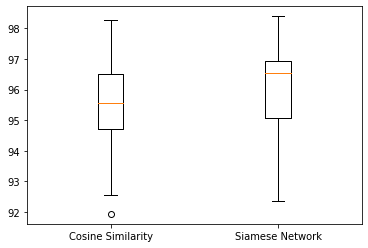

In [8]:
data = [cvTestscoresCosineAll,cvTestscoresSiameseAll]
names = ['Cosine Similarity', 'Siamese Network']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()